# Projet MIDL 2 - Tom LE BER (22308482) & Tony PEROTTINO (22303877)

## I. Présentation du projet MMPOSE

### 1. Objectifs

L'objectif de ce projet est d'analyser les mouvements de mains dans le contexte de vidéos de piano, préférentiellement vues du dessus.

Nous verrons que les modèles de MMPose permettent avec précision certains mouvements dans certaines configurations (par exemple la création du squelette de la main dans une configuration de piano avec une main unique), mais sont assez vite limités quand la tâche devient difficile (flou de mouvement sur la main, analyse des appuis sur les touches, prédiction de la prochaine note, etc.).

### 2. Démarche

Ce [Google Colab](https://colab.research.google.com/drive/1WdfeBuRD5V11CIqJnaqNyppdxTonHN3d?usp=sharing) va s'organiser en trois grandes étapes, installer mmpose et ses composantes puis tester les modèles trouvables dans le [model zoo](https://mmpose.readthedocs.io/en/latest/model_zoo/hand_2d_keypoint.html) de mmpose afin de les comparer et d'en dégager le meilleur modèle, pour enfin tester le meilleur modèle sur des prédiction d'appuis ou d'estimation de la prochaine note.

Les modèles que nous avons sélectionnés sont issus de la version 1.0.0 de MMPose, compatible avec la 1.3.2 que nous utilisons.

Pour choisir le meilleur modèle, on propose dans ce colab une comparaison des 10 modèles que nous avons trouvés et ensuite une reconstitution vidéo du modèle le plus performant sur une vidéo originale. On pourra aussi obtenir la vitesse de chaque point dans la dernière partie pour information de base de l'estimation des trajectoires.



### 3. Données

Disponibles dans le drive, nous avons au fil de nos expérimentations choisi 9 vidéos, accessibles à ce lien [Google Drive](https://drive.google.com/drive/folders/1AsCway7yl92WpXmiAsYyTYFcbufe6RTC?usp=sharing).

Il y a deux vidéos non originales correspondant à l'objectif que nous nous sommes fixées (vues du dessus). Dans ces deux vidéos, les mains ressortent car les prises sont faites dans l'obscurité et possèdent une visualisation des notes grâce à des logiciels proches de synthesia, embers ou seemusic. Elles ne correspondent malheureusement pas à ce qui est possible de faire avec les modèles mmpose qui ne peuvent regarder qu'une main à la fois.
*[chopin do#m rousseau, rachmaninoff solm kassia]*

La troisième vidéo est non originale et est une vidéo de pen-spinning, qui nous sert à tester les modèles sur des positions variables de la main (utile dans la comparaison des modèles pour retirer ceux qui sont non performants).
*[pen spinning.mp4]*

Les 4ème et 5ème vidéos sont des vidéos originales, la première est une capture d'une main avec un énorme contraste entre la main et l'arrière-plan, qui nous a servi à confirmer que la présence d'un contraste et un cadrage de la main suffisemment grand (où la main prend la majeure partie de l'écran) aide énormément à la bonne capture des points clés. La deuxième est une vidéo prise sur un piano, cadrée assez proche (4 octaves) proche et sous la lumière du jour qui nous sert de vidéo témoin qui démontre la qualité exacte du modèle.
*[main.mp4, wide putin tony.mp4]*

La 6ème, 7ème et 8ème sont des vidéos originales vues du dessus à la lumière artificielle sur un clavier complet, qui ont la particularité d'être jouées uniquement avec un seul doigt (index). Leur intérêt est de faciliter les prédictions de note et d'analyse d'appuis, en réduisant la quantité d'informations à un seul doigt. On peut alors comprendre les limites réelles du modèle de MMPose dans la prédiction de trajectoires. Ces 3 vidéos sont associées avec un fichier MIDI, qui permet d'avoir la réalité terrain. Un fichier au format MIDI est un format de données numériques qui ne contient pas de son audio, mais une série d'instructions (notes, rythme, vélocité) permettant à des instruments électroniques ou des logiciels de reproduire une œuvre musicale. Dans notre cas on utilisera ce fichier comme moyen de vérification des modèles de prédictions.
*[doigt 1.mp4, doigt 2.mp4, doigt sauts.mp4]*

La dernière vidéo est une filmée dans le mêmes conditions que les 3 précédentes à la différence que les deux mains jouent séparément sur leur moitié de l'écran (on peut alors analyser les mains en deux étapes), et est la vidéo la plus proche des objectifs fixés des vidéos 1 et 2 tout en étant compatible avec nos contraintes. Il s'agit d'une improvisation.
*[Impro tony 2 mains.mp4]*

## II. Installation des dépendances

L'objectif de cette partie est d'installer MMPose 1.3.2 et ses dépendances dans l'objectif de faire marcher des modèles de mains.

### 1. Installation des dépendances (CPU)

In [ ]:
import os
import re
import sys
import shutil
import subprocess
from pathlib import Path

mmpose_repository = "/content/mmpose_src"

In [ ]:
# Nettoyage des ressources présentes
%pip uninstall -y mmpose mmcv mmcv-lite mmdet >/dev/null 2>&1
if os.path.exists(mmpose_repository):
  shutil.rmtree(mmpose_repository, ignore_errors=True)

%pip install -q mmcv-lite==2.0.1
%pip install -q --no-deps mmdet==3.3.0
subprocess.check_call(["git","clone","--depth","1","--branch","v1.3.2","https://github.com/open-mmlab/mmpose.git", mmpose_repository])

# On retire les mentions de 'chumpy' pour éviter les codes en C++ précompilés qui ne correspondent pas à google colab
for filename in ["pyproject.toml","setup.cfg"]:
    config_file_path = os.path.join(mmpose_repository, filename)
    if os.path.exists(config_file_path):
        with open(config_file_path, "r", encoding="utf-8") as file:
            config_content = file.read()
        modified_content = config_content.replace("chumpy", "")
        with open(config_file_path, "w", encoding="utf-8") as file:
            file.write(modified_content)

# Installation de moviepy et pretty_midi (outils annexes) :
%pip uninstall -y moviepy decorator >/dev/null 2>&1
for path in ['/usr/local/lib/python3.12/dist-packages/moviepy', '/usr/local/lib/python3.12/dist-packages/moviepy-2.2.1.dist-info']:
    if os.path.exists(path):
        shutil.rmtree(path)
%pip install -q json-tricks munkres scipy opencv-python jedi>=0.16 moviepy==1.0.3 pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 893.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.0/715.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.7/452.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.3 MB/s eta 0:00:00


### 2. Suppression des imports `transformer_heads` et `EDPoseHead`



On supprime les imports `transformer_heads` et `EDPoseHead` du dépôt MMPose local dans `heads/__init__.py` et dans `models/__init__.py` afin de permettre à MMPose de fonctionner en mode CPU (similaire au Google Colab tutoriel).

In [ ]:
# Chemins vers les __init__ à patcher :
heads_init = os.path.join(mmpose_repository, "mmpose/models/heads/__init__.py")
trans_heads_init = os.path.join(
    mmpose_repository, "mmpose/models/heads/transformer_heads/__init__.py"
)

def patch_file(path, replacements):
    with open(path, "r", encoding="utf-8") as f:
        txt = f.read()
    new_txt = txt
    for pattern, repl in replacements:
        new_txt = re.sub(pattern, repl, new_txt)
    if new_txt != txt:
        with open(path, "w", encoding="utf-8") as f:
            f.write(new_txt)
        print(f"Patched: {path}")
    else:
        print(f"No change needed: {path}")

# On enlève l'import et l’export de EDPoseHead dans mmpose.models.heads :
patch_file(
    heads_init,
    [
        (r"\s*from\.transformer_heads import EDPoseHead\s*\n", "\n"), # Ligne du type: from .transformer_heads import EDPoseHead.
        (r"'EDPoseHead',\s*", ""), # '"EDPoseHead",' dans __all__.
    ],
)

# On enlève EDPoseHead dans transformer_heads/__init__.py :
patch_file(
    trans_heads_init,
    [
        (r"\s*from\.edpose_head import EDPoseHead\s*\n", "\n"),
        (r"'EDPoseHead',\s*", ""),
    ],
)

Patched: /content/mmpose_src/mmpose/models/heads/__init__.py
Patched: /content/mmpose_src/mmpose/models/heads/transformer_heads/__init__.py


In [ ]:
# On désactive totalement les "transformer_heads" (EDPose) :
heads_init_file_path = os.path.join(mmpose_repository, "mmpose/models/heads/__init__.py")
if os.path.exists(heads_init_file_path):
    with open(heads_init_file_path, "r", encoding="utf-8") as file:
        source_code_lines = file.read().splitlines()
    filtered_code_lines = [line for line in source_code_lines if "transformer_heads" not in line]
    cleaned_source_code = "\n".join(filtered_code_lines)
    with open(heads_init_file_path, "w", encoding="utf-8") as file:
        file.write(cleaned_source_code)

# On supprime le dossier des transformer_heads :
transformer_heads_dir = os.path.join(mmpose_repository, "mmpose/models/heads/transformer_heads")
if os.path.exists(heads_init_file_path):
  shutil.rmtree(transformer_heads_dir, ignore_errors=True)

In [ ]:
# Installe mmpose sans les conflits (dans le dossier préparé)
%pip install -q {mmpose_repository}

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### 3. Vérification du bon import des dépendances (CPU)

In [ ]:
import torch, torchvision, torchaudio, mmcv, mmengine

print(f"Torch : {torch.__version__}")
print(f"TorchVision : {torchvision.__version__}")
print(f"TorchAudio : {torchaudio.__version__}")
print(f"mmcv-lite : {mmcv.__version__}")
print(f"mmengine : {mmengine.__version__}")

Torch : 2.9.0+cpu
TorchVision : 0.24.0+cpu
TorchAudio : 2.9.0+cpu
mmcv-lite : 2.0.1
mmengine : 0.10.7


## III. Chargement des modèles MMPose

Cette partie sert à initialiser les modèles.

Chaque modèle se compose d'un fichier `.py` et d'un fichier `.pth` :
- Les `.py` sont directement trouvables dans le github de MMPose,
- Et les `.pth` dans le model zoo.

Le script `.py` contient les hyperparamètres et la description de l'architecture et le `.pth` les poids du modèle, c'est-à-dire son apprentissage.

In [ ]:
import requests
from urllib.parse import urlparse

### 1. Sélection des configurations de main en 2D

In [ ]:
MODELS_CONFIG = [
    {
        'name': 'Onehand10k_Hrnetv2_Dark',
        'config': '/content/mmpose_src/configs/hand_2d_keypoint/topdown_heatmap/onehand10k/td-hm_hrnetv2-w18_dark-8xb64-210e_onehand10k-256x256.py',
        'download_link': 'https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_onehand10k_256x256_dark-a2f80c64_20210330.pth'
    },
    {
        'name': 'Onehand10k_Hrnetv2_Udp',
        'config': '/content/mmpose_src/configs/hand_2d_keypoint/topdown_heatmap/onehand10k/td-hm_hrnetv2-w18_udp-8xb64-210e_onehand10k-256x256.py',
        'download_link': 'https://download.openmmlab.com/mmpose/hand/udp/hrnetv2_w18_onehand10k_256x256_udp-0d1b515d_20210330.pth'
    },
    {
        'name': 'Onehand10k_Hrnetv2',
        'config': '/content/mmpose_src/configs/hand_2d_keypoint/topdown_heatmap/onehand10k/td-hm_hrnetv2-w18_8xb64-210e_onehand10k-256x256.py',
        'download_link': 'https://download.openmmlab.com/mmpose/hand/hrnetv2/hrnetv2_w18_onehand10k_256x256-30bc9c6b_20210330.pth'
    },
    {
        'name': 'Onehand10k_Resnet',
        'config': '/content/mmpose_src/configs/hand_2d_keypoint/topdown_heatmap/onehand10k/td-hm_res50_8xb32-210e_onehand10k-256x256.py',
        'download_link': 'https://download.openmmlab.com/mmpose/hand/resnet/res50_onehand10k_256x256-739c8639_20210330.pth'
    },
    {
        'name': 'Onehand10k_Mobilenetv2',
        'config': '/content/mmpose_src/configs/hand_2d_keypoint/topdown_heatmap/onehand10k/td-hm_mobilenetv2_8xb64-210e_onehand10k-256x256.py',
        'download_link': 'https://download.openmmlab.com/mmpose/hand/mobilenetv2/mobilenetv2_onehand10k_256x256-f3a3d90e_20210330.pth'
    },
    {
        'name': 'RHD2D_Hrnetv2_Dark',
        'config': '/content/mmpose_src/configs/hand_2d_keypoint/topdown_heatmap/rhd2d/td-hm_hrnetv2-w18_dark-8xb64-210e_rhd2d-256x256.py',
        'download_link': 'https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_rhd2d_256x256_dark-4df3a347_20210330.pth'
    },
    {
        'name': 'RHD2D_Hrnetv2_Udp',
        'config': '/content/mmpose_src/configs/hand_2d_keypoint/topdown_heatmap/rhd2d/td-hm_hrnetv2-w18_udp-8xb64-210e_rhd2d-256x256.py',
        'download_link': 'https://download.openmmlab.com/mmpose/hand/udp/hrnetv2_w18_rhd2d_256x256_udp-63ba6007_20210330.pth'
    },
    {
        'name': 'RHD2D_Hrnetv2',
        'config': '/content/mmpose_src/configs/hand_2d_keypoint/topdown_heatmap/rhd2d/td-hm_hrnetv2-w18_8xb64-210e_rhd2d-256x256.py',
        'download_link': 'https://download.openmmlab.com/mmpose/hand/hrnetv2/hrnetv2_w18_rhd2d_256x256-95b20dd8_20210330.pth'
    },
    {
        'name': 'RHD2D_Resnet',
        'config': '/content/mmpose_src/configs/hand_2d_keypoint/topdown_heatmap/rhd2d/td-hm_res50_8xb64-210e_rhd2d-256x256.py',
        'download_link': 'https://download.openmmlab.com/mmpose/hand/resnet/res50_rhd2d_256x256-5dc7e4cc_20210330.pth'
    },
    {
        'name': 'RHD2D_Mobilenetv2',
        'config': '/content/mmpose_src/configs/hand_2d_keypoint/topdown_heatmap/rhd2d/td-hm_mobilenetv2_8xb64-210e_rhd2d-256x256.py',
        'download_link': 'https://download.openmmlab.com/mmpose/hand/mobilenetv2/mobilenetv2_rhd2d_256x256-85fa02db_20210330.pth'
    }
]

### 2. Téléchargement des fichiers `.pth` associé à chaque modèle de main en 2D choisi

In [ ]:
CHECKPOINT_DIR = Path("/content/checkpoints")

def download_all_checkpoints(models_config, destination_dir = CHECKPOINT_DIR):
    """
    Télécharge tous les checkpoints dans destination_dir et met aussi à jour models_config[model]['checkpoint'] avec le bon chemin local pour chaque modèle.
    """
    destination_dir.mkdir(parents=True, exist_ok=True)

    for model in models_config:
        url = model["download_link"]
        fname = Path(urlparse(url).path).name
        out_path = destination_dir / fname

        # On met à jour le champ 'checkpoint' vers le chemin d'accès local du fichier '.pth' :
        model["checkpoint"] = str(out_path)

        # Si le fichier '.pth' existe déjà, on passe :
        if out_path.exists():
            print(f"[OK] déjà présent : {fname}")
            continue

        # Sinon, s'il n'existe pas, on le télécharge :
        print(f"[DL] {model['name']} -> {fname}")
        with requests.get(url) as r:
            r.raise_for_status()
            with open(out_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        f.write(chunk)

    return models_config

# Téléchargement des fichiers '.pth' et création du chant 'checkpoint' pour chaque modèle dans 'MODELS_CONFIG' :
MODELS_CONFIG = download_all_checkpoints(MODELS_CONFIG)

[DL] Onehand10k_Hrnetv2_Dark -> hrnetv2_w18_onehand10k_256x256_dark-a2f80c64_20210330.pth
[DL] Onehand10k_Hrnetv2_Udp -> hrnetv2_w18_onehand10k_256x256_udp-0d1b515d_20210330.pth
[DL] Onehand10k_Hrnetv2 -> hrnetv2_w18_onehand10k_256x256-30bc9c6b_20210330.pth
[DL] Onehand10k_Resnet -> res50_onehand10k_256x256-739c8639_20210330.pth
[DL] Onehand10k_Mobilenetv2 -> mobilenetv2_onehand10k_256x256-f3a3d90e_20210330.pth
[DL] RHD2D_Hrnetv2_Dark -> hrnetv2_w18_rhd2d_256x256_dark-4df3a347_20210330.pth
[DL] RHD2D_Hrnetv2_Udp -> hrnetv2_w18_rhd2d_256x256_udp-63ba6007_20210330.pth
[DL] RHD2D_Hrnetv2 -> hrnetv2_w18_rhd2d_256x256-95b20dd8_20210330.pth
[DL] RHD2D_Resnet -> res50_rhd2d_256x256-5dc7e4cc_20210330.pth
[DL] RHD2D_Mobilenetv2 -> mobilenetv2_rhd2d_256x256-85fa02db_20210330.pth


## IV. Test des modèles sur les vidéos



### 0. Téléchargement de la vidéo et définition des paramètres

In [ ]:
import os
from google.colab import files

os.makedirs("/content/data", exist_ok=True)

uploaded = files.upload()
src_name = next(iter(uploaded)) # Nom du fichier téléchargé.

if len(uploaded) != 1 or not src_name.lower().endswith(".mp4"):
    raise ValueError("Merci d'uploader exactement 1 fichier vidéo au format MP4.")

VIDEO_PATH = "/content/data/video.mp4"
with open(VIDEO_PATH, "wb") as f:
    f.write(uploaded[src_name])


Saving doigt 1 small.mp4 to doigt 1 small.mp4


In [ ]:
OUTPUT_DIR = "/content/output"
VIS_THRESHOLD = 0.2
COLORS = [
    (255, 255, 0),   # Cyan
    (0, 255, 255),   # Jaune
    (255, 0, 255),   # Magenta
    (0, 0, 255),     # Rouge
    (0, 255, 0),     # Vert
    (255, 0, 0),     # Bleu
    (0, 165, 255),   # Orange
    (203, 192, 255), # Rose bonbon
    (128, 0, 128),   # Violet foncé
    (0, 128, 0)      # Vert sapin
]
START_TIME_SEC = 0
END_TIME_SEC = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
HAND_SKELETON_LINKS = [
    (0, 1), (1, 2), (2, 3), (3, 4),        # Pouce
    (0, 5), (5, 6), (6, 7), (7, 8),        # Index
    (0, 9), (9, 10), (10, 11), (11, 12),   # Majeur
    (0, 13), (13, 14), (14, 15), (15, 16), # Annulaire
    (0, 17), (17, 18), (18, 19), (19, 20)  # Auriculaire
]

### 1. Utilitaires/Installations

Dans cette catégorie, on installe les dépendances manquantes concernant les modèles 2D et de certains utilitaires permettant (par exemple) la manipulation de vidéos et d'images. On initialise MMPose 1.3.2.

In [ ]:
import re
import os
import csv
import cv2
import traceback
import importlib.util
import matplotlib.pyplot as plt
import numpy as np
from contextlib import ExitStack, contextmanager
from moviepy.editor import VideoFileClip, ImageSequenceClip

print(f"mmpose.apis visible == {importlib.util.find_spec("mmpose.apis") is not None}")

# 1. Vérification des configurations
if not os.path.isdir(os.path.join(mmpose_repository, "configs/_base_/datasets")):
    raise FileNotFoundError("Configurations introuvables dans le repository MMPose.")

# 2. Changement de répertoire
os.chdir(mmpose_repository)
print(f"CWD actuel = {os.getcwd()}")
print(f"Base config exists = {os.path.exists('configs/_base_/datasets/onehand10k.py')}")

# 3. Imports MMPose 1.3.2
import mmcv
from mmpose.apis import init_model, inference_topdown
from mmpose.utils import register_all_modules

register_all_modules() # Obligatoire dans la version 1.3.2 de mmpose.

mmpose.apis visible == True
CWD actuel = /content/mmpose_src
Base config exists = True


  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '



#### Puis les fonctions utilitaires personnalisées permettant ensuite de faire tourner les fonctions de comparaison et de visualisation des modèles.

In [ ]:
def load_mmpose_models(models_config: list) -> list:
    models = []
    for model_config in models_config:
        try:
            model = init_model(model_config["config"], model_config["checkpoint"], device=DEVICE)
            setattr(model, 'model_name', model_config["name"])
            setattr(model, 'skeleton', HAND_SKELETON_LINKS)
            setattr(model, 'pose_link_colors', COLORS[0])
            models.append(model)
            print(f"Modèle chargé : {model_config['name']}")

        except Exception as e:
            models.append(None)
            print(f"Erreur lors du chargement du modèle {model_config['name']}: {repr(e)}")
            traceback.print_exc()
    return models

def find_bbox_from_tiling(model, frame, tile_size=256, overlap=0.1, previous_best_score=-1.0):
    """
    Découpe l'image en tuiles de 'tile_size'x'tile_size' et cherche la main.
    1. Score < 0.25          : On abandonne et renvoie la scène entière.
    2. 0.25 <= Score <= 0.40 : On affine la recherche par récursion (+ overlap).
    3. Score > 0.40          : On a une bonne détection, on renvoie la bbox (+10%).
    """
    h, w = frame.shape[:2]
    best_overall_score = -1.0
    best_keypoints = None
    stride = max(1, int(tile_size * (1 - overlap)))

    # Pavage 2D
    for y in range(0, h - stride, stride):
        for x in range(0, w - stride, stride):
            x2, y2 = min(x + tile_size, w), min(y + tile_size, h)
            current_tile_bbox = [x, y, x2, y2]
            kpts, scores = run_inference_on_tile(model, frame, current_tile_bbox)

            if kpts is not None:
                mean_score = np.mean(scores)
                if mean_score > best_overall_score:
                    best_overall_score = mean_score
                    best_keypoints = kpts

    # PALIER 1 : Score initial trop faible
    if best_overall_score < 0.25:
        print(f"Score trop faible ({best_overall_score:.2f}). Scène entière.")
        return np.array([[0, 0, w, h]], dtype=np.float32)

    # PALIER 2 : Score incertain -> On tente d'affiner ou on abandonne si pas d'amélioration
    if previous_best_score > 0 and best_overall_score < previous_best_score:
        print(f"Dégradation du score ({previous_best_score:.2f} -> {best_overall_score:.2f}). Fausse alerte détectée.")
        return np.array([[0, 0, w, h]], dtype=np.float32)
    elif 0.25 <= best_overall_score <= 0.4:
        new_overlap = overlap + 0.2
        if new_overlap < 0.9:
            print(f"Score incertain ({best_overall_score:.2f}). Affinage avec overlap {new_overlap:.2f}...")
            # On passe le score actuel pour comparer au prochain tour
            return find_bbox_from_tiling(model, frame, tile_size, new_overlap, best_overall_score)

    # PALIER 3 : Très bon score ou fin de récursion réussie
    x_min, y_min = np.min(best_keypoints, axis=0)
    x_max, y_max = np.max(best_keypoints, axis=0)

    width, height = x_max - x_min, y_max - y_min
    margin = max(width, height) * 0.10

    return np.array([[
        max(0, x_min - margin),
        max(0, y_min - margin),
        min(w, x_max + margin),
        min(h, y_max + margin)
    ]], dtype=np.float32)

def find_bbox(model, frame, last_points_csv_path) -> np.ndarray:
    # CAS 1 : On n'a pas de référenciel pour la frame actuelle :
    if last_points_csv_path is None or not os.path.exists(last_points_csv_path):
        print("Initialisation ou perte de suivi : Lancement du pavage récursif...")
        return find_bbox_from_tiling(model, frame,256*2)

    try:
        x_coords, y_coords, scores = [], [], []

        with open(last_points_csv_path, mode='r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                if row['x'] and row['x'].replace('.','',1).isdigit():
                    x_coords.append(float(row['x']))
                    y_coords.append(float(row['y']))
                    scores.append(float(row['score']))

        # Score moyen trop faible pour considérer les anciens keypoints comme base
        if not scores or np.mean(scores) < 0.25:
            print("Initialisation ou perte de suivi : Lancement du pavage récursif...")
            return find_bbox_from_tiling(model, frame,256*2)

    # CAS 2 : On prend les extremums des points précédents auquels on ajoute 10% (Inchangé) :
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)
        width = x_max - x_min
        height = y_max - y_min

        margin = max(width, height) * 0.10
        frame_height, frame_width = frame.shape[:2]

        x1 = max(0, x_min - margin)
        y1 = max(0, y_min - margin)
        x2 = min(frame_width, x_max + margin)
        y2 = min(frame_height, y_max + margin)

        return np.array([[x1, y1, x2, y2]], dtype=np.float32)

    except Exception as e:
        print(f"Erreur lecture CSV : {e}")
        return find_bbox_from_tiling(model, frame)

def run_inference_on_tile(model, frame, bbox):
    """Lance l'inférence sur une zone précise (bbox format [x1, y1, x2, y2])"""
    results = inference_topdown(model, frame, np.array([bbox], dtype=np.float32))

    if results and len(results[0].pred_instances) > 0:
        instance = results[0].pred_instances
        keypoints = instance.keypoints[0]
        scores = instance.keypoint_scores[0]

        if hasattr(keypoints, 'cpu'):
            keypoints = keypoints.cpu().numpy()
            scores = scores.cpu().numpy()

        return keypoints, scores
    return None, None

def run_inference(model, frame, frame_idx) -> tuple:
    last_points_csv_path = None
    model_name = getattr(model, "model_name", "default_model")

    if frame_idx > 0:
        candidate = os.path.join(OUTPUT_DIR, model_name, f"keypoints_frame_{frame_idx - 1}.csv")
        if os.path.exists(candidate):
            last_points_csv_path = candidate

    bboxes = find_bbox(model, frame, last_points_csv_path)

    results = inference_topdown(model, frame, bboxes)
    if results and len(results[0].pred_instances) > 0:
        keypoints = results[0].pred_instances.keypoints[0][:, :2]
        scores = results[0].pred_instances.keypoint_scores[0]

        if hasattr(keypoints, 'cpu'):
            return keypoints.cpu().numpy(), scores.cpu().numpy()
        return keypoints, scores.flatten()

    return None, None

def save_keypoints_to_csv(keypoints, scores, model_name: str, current_frame_num: int):
    model_dir = os.path.join(OUTPUT_DIR, model_name)
    os.makedirs(model_dir, exist_ok=True)
    csv_path = os.path.join(model_dir, f"keypoints_frame_{current_frame_num}.csv")

    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["x", "y", "score"])
        if keypoints is not None and scores is not None:
            for kp_x, kp_y, score in zip(keypoints[:, 0], keypoints[:, 1], scores):
                writer.writerow([kp_x, kp_y, score])
        else:
            writer.writerow(["no hand detected"])

def draw_keypoints_on_frame(frame: torch.Tensor, keypoints, scores, color: tuple, threshold: float) -> torch.Tensor:
    if keypoints is not None and scores is not None:
        for i in range(len(keypoints)):
            if scores[i] > threshold:
                cv2.circle(frame, (int(keypoints[i][0]), int(keypoints[i][1])), 5, color, -1)
    return frame

def draw_skeleton_on_frame(frame: np.ndarray, keypoints, scores, skeleton, threshold: float, color: tuple) -> np.ndarray:
    if keypoints is None or scores is None:
        return frame

    if skeleton is not None:
        for (i, j) in skeleton:
            if scores[i] > threshold and scores[j] > threshold:
                pt1 = (int(keypoints[i][0]), int(keypoints[i][1]))
                pt2 = (int(keypoints[j][0]), int(keypoints[j][1]))

                cv2.line(frame, pt1, pt2, color, 2)

    frame = draw_keypoints_on_frame(frame,keypoints,scores,color,threshold)
    return frame

def draw_legend(frame: torch.Tensor, models_config: list, colors: list) -> torch.Tensor:
    y0, dy = 20, 20
    for idx, model in enumerate(models_config):
        color = colors[idx % len(colors)]
        cv2.putText(frame, model["name"], (10, y0 + idx * dy),cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    return frame

def reconstruct_video_from_frames(frames_directory: str, original_video_path: str, output_video_name: str, start_time: float, end_time: float):
    print("\nDébut de la reconstruction vidéo...")

    # 1. Récupérer et trier les frames
    def frame_num(name: str) -> int:
        number = re.search(r'frame_(\d+)\.jpg$', name)
        return int(number.group(1)) if number else -1
    frames = [frame for frame in os.listdir(frames_directory) if re.match(r'frame_\d+\.jpg$', frame)]

    if not frames:
        print(f"ERREUR : aucune frame trouvée dans {frames_directory}")
        return None

    frames.sort(key=frame_num)
    frame_paths = [os.path.join(frames_directory, frame) for frame in frames]

    # 2. Récupérer l'audio de la vidéo
    original_video = VideoFileClip(original_video_path)
    audio = None
    if original_video.audio is not None:
        audio = original_video.audio.subclip(float(start_time), min(float(end_time), float(original_video.duration)))

    # 3. Re-construire la vidéo (audio + vidéo)
    fps = float(original_video.fps) if original_video.fps else 30.0
    clip = ImageSequenceClip(frame_paths, fps=fps)
    if audio is not None:
        if hasattr(clip, "with_audio"):
            clip = clip.with_audio(audio)
        else:
            clip = clip.set_audio(audio)

    # 4. Sauvegarde
    output_video_path = os.path.join(frames_directory, output_video_name)
    os.makedirs(os.path.dirname(output_video_path) or ".", exist_ok=True)
    if os.path.exists(output_video_path):
        os.remove(output_video_path)

    clip.write_videofile(output_video_path,codec="libx264",audio_codec="aac",fps=fps)

    # 5. Fermeture des ressources
    clip.close()
    original_video.close()

    print(f"Vidéo reconstruite avec succès à : {output_video_path} (FPS={fps:.2f})")
    return output_video_path

def get_keypoints_from_models(video_path, models_config, start_time, end_time):
    loaded_models = load_mmpose_models(models_config)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Erreur: Impossible d'ouvrir le fichier vidéo à {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    current_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

    while current_frame <= end_frame:
        read_success, frame = cap.read()
        if not read_success:
            break

        for i, model in enumerate(loaded_models):
            if model is not None:
                keypoints, scores = run_inference(model, frame, current_frame)
                save_keypoints_to_csv(keypoints, scores, models_config[i]["name"], current_frame)

        current_frame += 1
    cap.release()
    return fps

def get_velocity_from_keypoints(model_name, start_frame, end_frame, fps):
    """ Unité : pixels/secondes | Formule : sqrt( (x_t - x_t-1)² + (y_t - y_t-1)² )"""
    model_dir = os.path.join(OUTPUT_DIR, model_name)
    output_csv = os.path.join(model_dir, "velocities.csv")

    velocities = []
    prev_keypoints = None
    for num_frame in range(start_frame, end_frame + 1):
        csv_path = os.path.join(model_dir, f"keypoints_frame_{num_frame}.csv")
        if not os.path.exists(csv_path): continue

        curr_keypoints = []
        with open(csv_path, "r") as f:
            reader = csv.reader(f)
            next(reader, None)
            for row in reader:
                if "no hand detected" in row[0]: continue
                curr_keypoints.append([float(row[0]), float(row[1])])
        curr_keypoints = np.array(curr_keypoints)

        # Calcul de la vitesse si on a une frame précédente
        if prev_keypoints is not None and curr_keypoints.shape == prev_keypoints.shape:
            distances = np.linalg.norm(curr_keypoints - prev_keypoints, axis=1)
            speed = distances * fps
            velocities.append([num_frame] + speed.tolist())

        prev_keypoints = curr_keypoints

    # Sauvegarde des vitesses dans un nouveau csv
    if velocities:
        with open(output_csv, "w", newline="") as f:
            writer = csv.writer(f)
            header = ["frame_idx"] + [f"kp_{i}_speed" for i in range(len(velocities[0])-1)]
            writer.writerow(header)
            writer.writerows(velocities)

    return output_csv

### 2. Test des modèles de la catégorie III

#### A. Comparaison des modèles

La première fonction de test prend une liste de modèles (dans le format de `MODELS_CONFIG`) et les affiche sur les frames une à une avec une légende et des couleurs différentes pour chaque modèles. On peut créer une vidéo à partir de ces frames grâce à la fonction utilitaire associée.

**ATTENTION : LE BLOC DE CODE CI-DESSOUS EST PARTICULIEREMENT LONG A S'EXECUTER, PARTICULIEREMENT DEPUIS LA DERNIERE VERSION DU CODE. N'HESITEZ PAS A COMMENTER CE BLOC DE CODE SI VOUS SOUHAITEZ PASSER A LA SUITE DU NOTEBOOK.**

In [ ]:
def compare_models(video_path: str, models_config: list, colors: list, start_time: int, end_time: int):
    loaded_models = load_mmpose_models(models_config)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Erreur: Impossible d'ouvrir le fichier vidéo à {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    current_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
    while current_frame <= end_frame:
        read_success, original_frame = cap.read()
        if not read_success:
            break

        frame = original_frame.copy()

        for i, model in enumerate(loaded_models):
            if model is None:
                continue

            model_name = models_config[i]["name"]
            color = colors[i % len(colors)]

            keypoints, scores = run_inference(model, original_frame.copy(), current_frame)
            save_keypoints_to_csv(keypoints, scores, model_name, current_frame)
            frame = draw_keypoints_on_frame(frame,keypoints,scores,color,VIS_THRESHOLD)

        final_frame = draw_legend(frame, models_config, colors)

        os.makedirs(OUTPUT_DIR, exist_ok=True)
        final_frame_path = os.path.join(OUTPUT_DIR, f"frame_{current_frame}.jpg")
        cv2.imwrite(final_frame_path, final_frame)

        print(f"Frame {current_frame} générée")
        current_frame += 1

    cap.release()
    print("Traitement terminé !")

compare_models(VIDEO_PATH, MODELS_CONFIG, COLORS, START_TIME_SEC, END_TIME_SEC)
reconstruct_video_from_frames(OUTPUT_DIR, VIDEO_PATH, "/content/output_video.mp4", START_TIME_SEC, END_TIME_SEC)

Loads checkpoint by local backend from path: /content/checkpoints/hrnetv2_w18_onehand10k_256x256_dark-a2f80c64_20210330.pth
Modèle chargé : Onehand10k_Hrnetv2_Dark
Loads checkpoint by local backend from path: /content/checkpoints/hrnetv2_w18_onehand10k_256x256_udp-0d1b515d_20210330.pth
Modèle chargé : Onehand10k_Hrnetv2_Udp
Loads checkpoint by local backend from path: /content/checkpoints/hrnetv2_w18_onehand10k_256x256-30bc9c6b_20210330.pth
Modèle chargé : Onehand10k_Hrnetv2
Loads checkpoint by local backend from path: /content/checkpoints/res50_onehand10k_256x256-739c8639_20210330.pth
Modèle chargé : Onehand10k_Resnet
Loads checkpoint by local backend from path: /content/checkpoints/mobilenetv2_onehand10k_256x256-f3a3d90e_20210330.pth
Modèle chargé : Onehand10k_Mobilenetv2
Loads checkpoint by local backend from path: /content/checkpoints/hrnetv2_w18_rhd2d_256x256_dark-4df3a347_20210330.pth
Modèle chargé : RHD2D_Hrnetv2_Dark
Loads checkpoint by local backend from path: /content/checkpo

MoviePy - Done.
Moviepy - Writing video /content/output_video.mp4



Moviepy - Done !
Moviepy - video ready /content/output_video.mp4
Vidéo reconstruite avec succès à : /content/output_video.mp4 (FPS=30.00)


'/content/output_video.mp4'

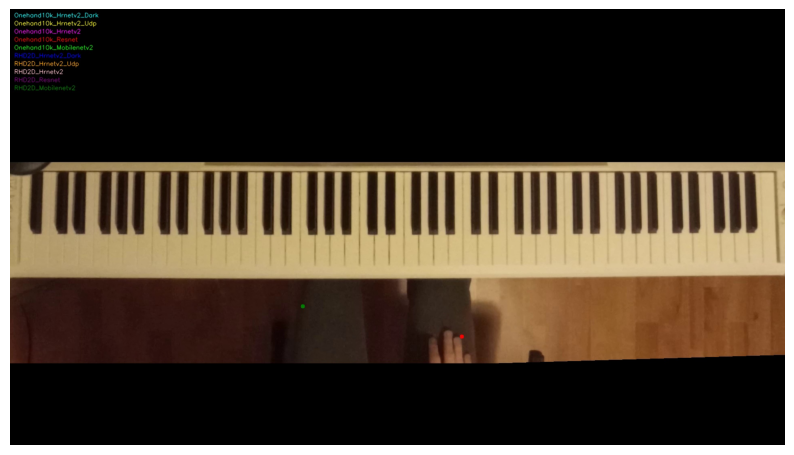

In [ ]:
frame_path = f"/content/output/frame_{START_TIME_SEC*30 + 1}.jpg"
img_bgr = cv2.imread(frame_path)
if img_bgr is None:
    raise FileNotFoundError(frame_path)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

#### B. Dessin du squelette de la main

La deuxième fonction dessine un squelette de la main en fonction des points générés par le modèle choisi. On peut aussi choisir de reconstituer sa vidéo.

In [ ]:
def draw_skeleton_on_video(video_path: str, models_config: list, start_time: int, end_time: int):
    loaded_models = load_mmpose_models(models_config)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Erreur: Impossible d'ouvrir le fichier vidéo à {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    current_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

    while current_frame <= end_frame:
        read_success, original_frame = cap.read()
        if not read_success:
            break

        frame = original_frame.copy()

        for i, model in enumerate(loaded_models):
            if model is None:
                continue

            keypoints, scores = run_inference(model, original_frame.copy(), current_frame)
            save_keypoints_to_csv(keypoints, scores, models_config[i]["name"], current_frame)

            frame = draw_skeleton_on_frame(frame, keypoints, scores, model.skeleton, VIS_THRESHOLD, model.pose_link_colors)

        frame_path = os.path.join(OUTPUT_DIR, f"frame_{current_frame}.jpg")
        cv2.imwrite(frame_path, frame)

        print(f"Frame {current_frame}/{end_frame} générée")
        current_frame += 1

    cap.release()
    print("Traitement terminé !")

draw_skeleton_on_video(VIDEO_PATH, [MODELS_CONFIG[0]], START_TIME_SEC, END_TIME_SEC)
reconstruct_video_from_frames(OUTPUT_DIR, VIDEO_PATH, "/content/output_video.mp4", START_TIME_SEC, END_TIME_SEC)

Loads checkpoint by local backend from path: /content/checkpoints/hrnetv2_w18_onehand10k_256x256_dark-a2f80c64_20210330.pth
Modèle chargé : Onehand10k_Hrnetv2_Dark
Initialisation ou perte de suivi : Lancement du pavage récursif...
Score incertain (0.29). Affinage avec overlap 0.30...
Score incertain (0.35). Affinage avec overlap 0.50...
Score incertain (0.35). Affinage avec overlap 0.70...
Score incertain (0.36). Affinage avec overlap 0.90...
Frame 0/300 générée
Initialisation ou perte de suivi : Lancement du pavage récursif...
Score incertain (0.28). Affinage avec overlap 0.30...
Score incertain (0.36). Affinage avec overlap 0.50...
Dégradation du score (0.36 -> 0.34). Fausse alerte détectée.
Frame 1/300 générée
Initialisation ou perte de suivi : Lancement du pavage récursif...
Score incertain (0.32). Affinage avec overlap 0.30...
Score incertain (0.34). Affinage avec overlap 0.50...
Score incertain (0.34). Affinage avec overlap 0.70...
Dégradation du score (0.34 -> 0.34). Fausse aler

MoviePy - Done.
Moviepy - Writing video /content/output_video.mp4



Moviepy - Done !
Moviepy - video ready /content/output_video.mp4
Vidéo reconstruite avec succès à : /content/output_video.mp4 (FPS=30.00)


'/content/output_video.mp4'

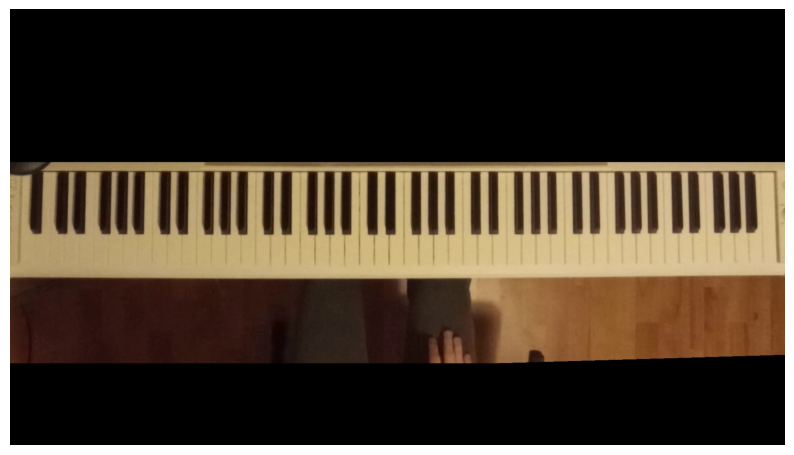

In [ ]:
frame_path = f"/content/output/frame_{START_TIME_SEC*30 + 1}.jpg"
img_bgr = cv2.imread(frame_path)
if img_bgr is None:
    raise FileNotFoundError(frame_path)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

Après nos expérimentations, nous avons conclu que le meilleur modèle 2D pour l'analyse des mains est `Onehand10k_Hrnetv2_Dark`.

## V. Analyse des trajectoires

Nous avons réalisé deux analyses de trajectoire.

### 1. Evolution de la vitesse des différents joints d'une main en fonction du temps


La première analyse que nous avons réalisée est une évolution de la vitesse des différents joints de la main étudiée en fonction du temps.

La fonction suivante permet de générer un fichier `.csv` contenant la vitesse de chaque keypoint, en pixels par seconde.

La méthode de calcul trouve la vitesse à l'aide du point précédent.
La formule est la suivante :
$$
\sqrt{(x_t - x_{t-1})^2 + (y_t - y_{t-1})^2}
$$

On peut ensuite y générer les graphiques associés à chaque modèle.

--- Étape 2 : Calcul des vitesses ---
Vitesses calculées pour Onehand10k_Hrnetv2_Dark -> /content/output/Onehand10k_Hrnetv2_Dark/velocities.csv
Vitesses calculées pour Onehand10k_Hrnetv2_Udp -> /content/output/Onehand10k_Hrnetv2_Udp/velocities.csv
Vitesses calculées pour Onehand10k_Hrnetv2 -> /content/output/Onehand10k_Hrnetv2/velocities.csv
Vitesses calculées pour Onehand10k_Resnet -> /content/output/Onehand10k_Resnet/velocities.csv
Vitesses calculées pour Onehand10k_Mobilenetv2 -> /content/output/Onehand10k_Mobilenetv2/velocities.csv
Vitesses calculées pour RHD2D_Hrnetv2_Dark -> /content/output/RHD2D_Hrnetv2_Dark/velocities.csv
Vitesses calculées pour RHD2D_Hrnetv2_Udp -> /content/output/RHD2D_Hrnetv2_Udp/velocities.csv
Vitesses calculées pour RHD2D_Hrnetv2 -> /content/output/RHD2D_Hrnetv2/velocities.csv
Vitesses calculées pour RHD2D_Resnet -> /content/output/RHD2D_Resnet/velocities.csv
Vitesses calculées pour RHD2D_Mobilenetv2 -> /content/output/RHD2D_Mobilenetv2/velocities.csv


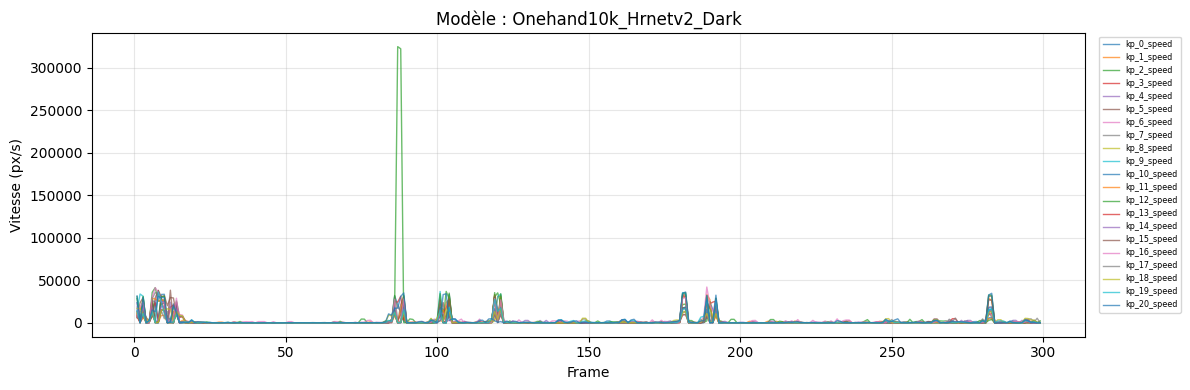

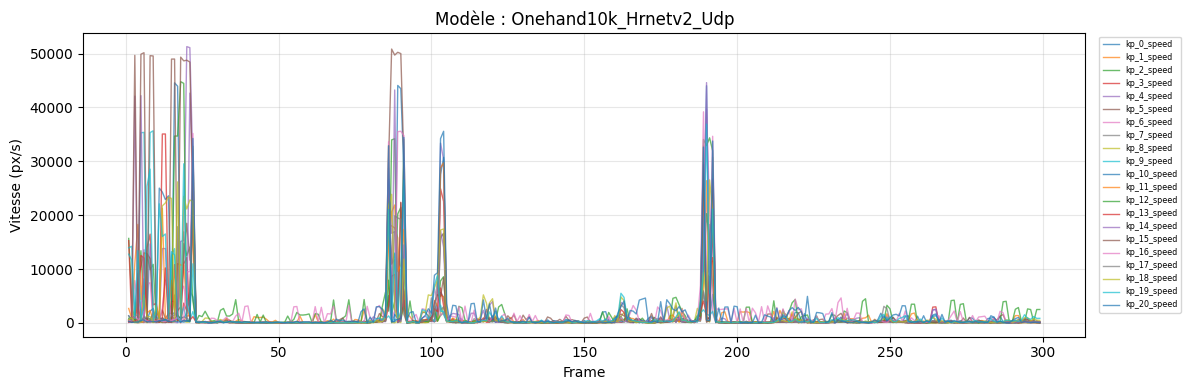

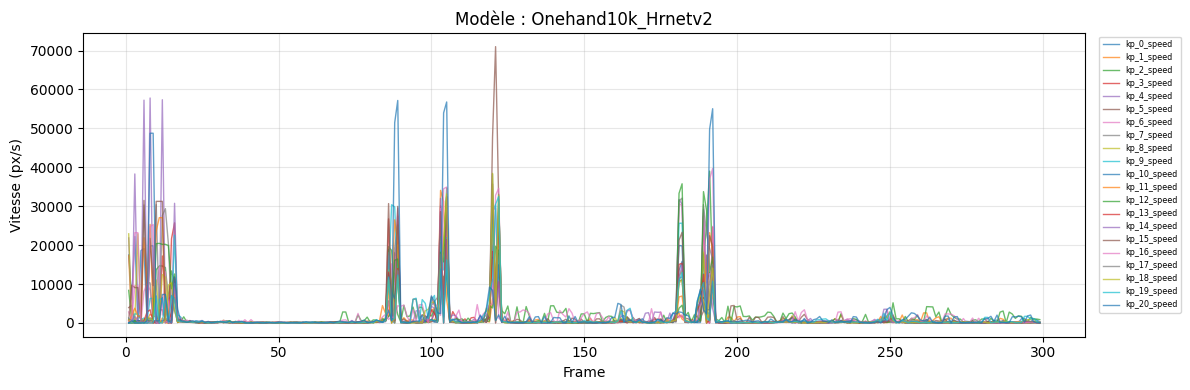

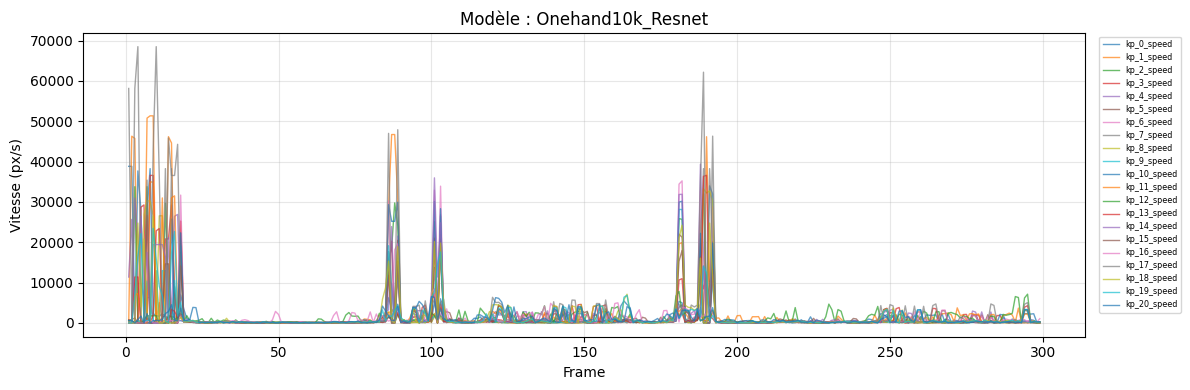

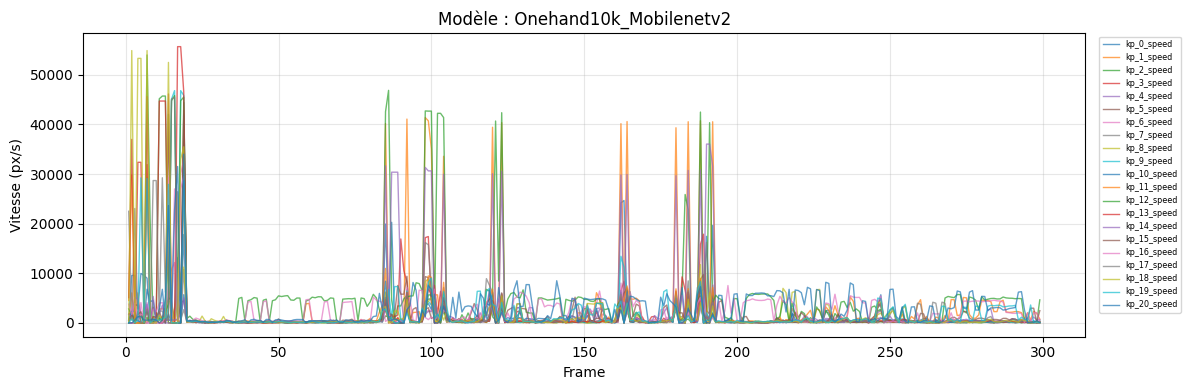

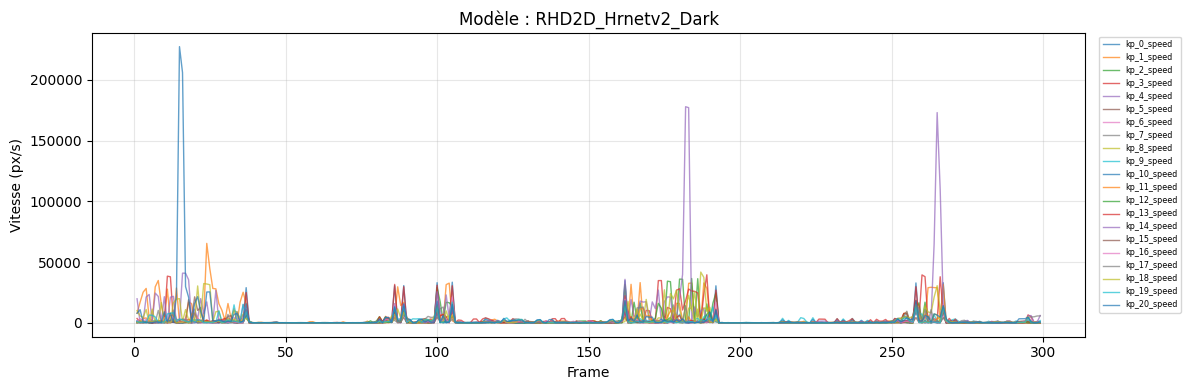

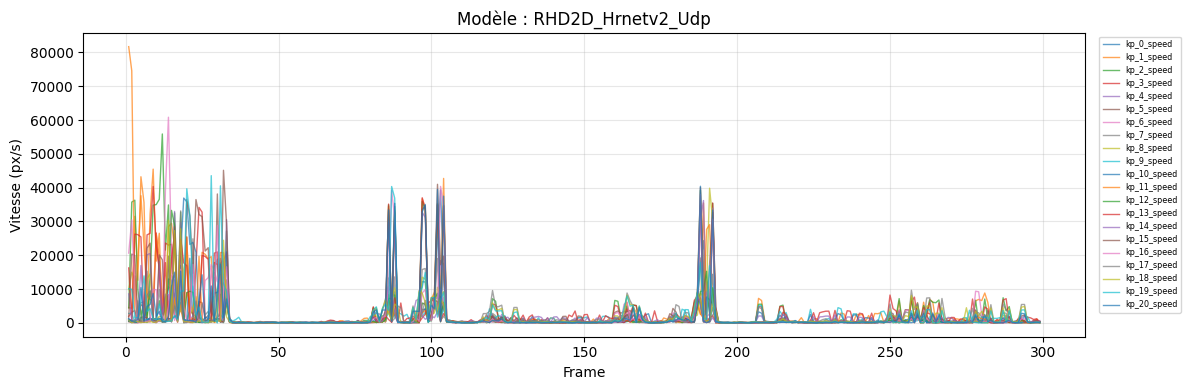

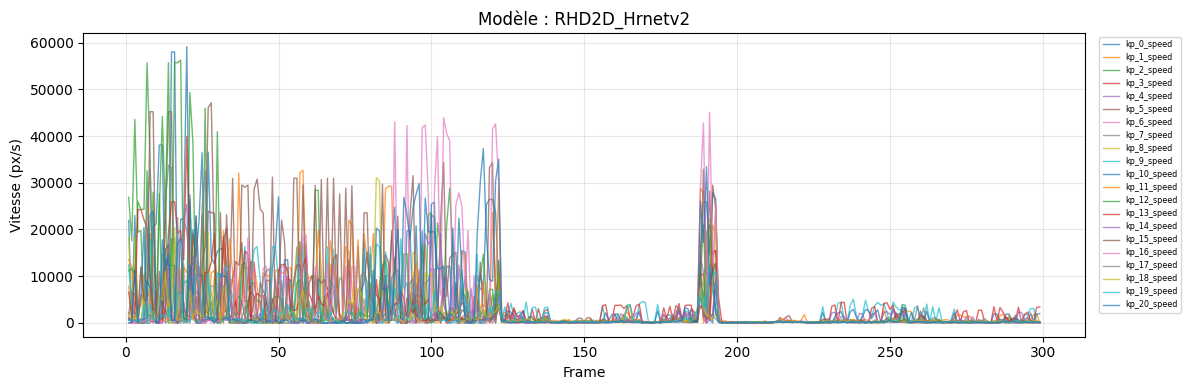

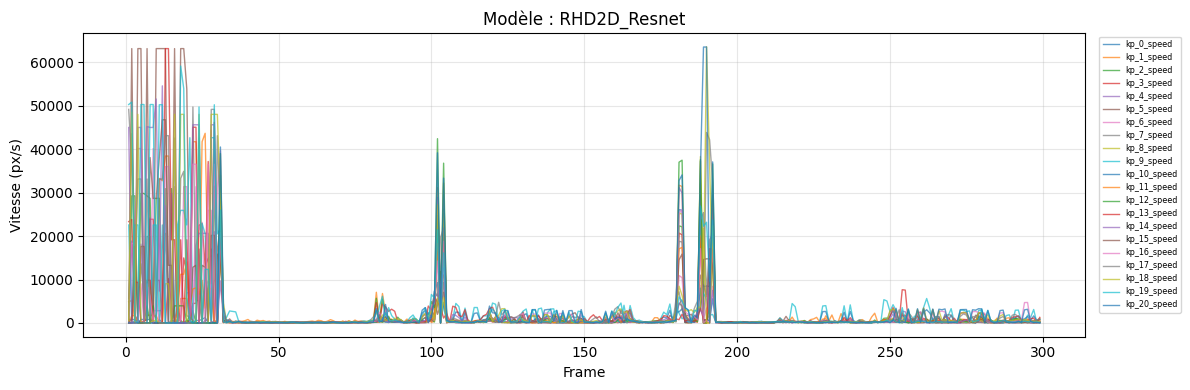

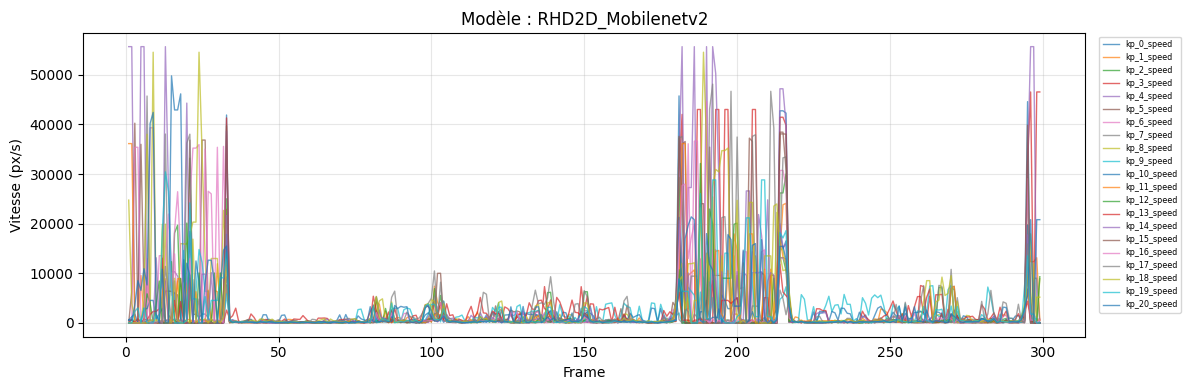

In [ ]:
def get_velocities_from_models(video_path, models_config, start_time, end_time, calculate_only_velocities=False):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    if not calculate_only_velocities:
        print("--- Étape 1 : Extraction des keypoints ---")
        get_keypoints_from_models(video_path, models_config, start_time, end_time)

    print("--- Étape 2 : Calcul des vitesses ---")
    for model in models_config:
        # On utilise les variables définies plus haut
        res_path = get_velocity_from_keypoints(model["name"], start_frame, end_frame, fps)
        print(f"Vitesses calculées pour {model['name']} -> {res_path}")

def plot_velocities(models_config, output_dir):
    for model in models_config:
        model_name = model["name"]
        csv_path = os.path.join(output_dir, model_name, "velocities.csv")
        if not os.path.exists(csv_path):
            continue

        frames = []
        kp_velocities = {}
        with open(csv_path, "r") as f:
            reader = csv.DictReader(f)
            for row in reader:
                frames.append(int(row["frame_idx"]))
                for col_name, value in row.items():
                    if col_name.startswith("kp_"):
                        if col_name not in kp_velocities:
                            kp_velocities[col_name] = []
                        kp_velocities[col_name].append(float(value))

        if frames:
            plt.figure(figsize=(12, 4))
            for kp_name, speeds in kp_velocities.items():
                plt.plot(frames, speeds, label=kp_name, alpha=0.7, linewidth=1)
            plt.title(f"Modèle : {model_name}")
            plt.xlabel("Frame")
            plt.ylabel("Vitesse (px/s)")
            plt.grid(True, alpha=0.3)
            plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='xx-small', ncol=1)
            plt.tight_layout()
            plt.show()

get_velocities_from_models(VIDEO_PATH, MODELS_CONFIG, START_TIME_SEC, END_TIME_SEC,True)
plot_velocities(MODELS_CONFIG, OUTPUT_DIR)

### 2. Estimation des notes pressées

La deuxième méthode d’analyse de trajectoire que nous avons développée est beaucoup plus complexe et repose sur un **étalonnage des touches du piano** accompagné du **filtre de Savitzky-Golay** (au sens traitement du signal).  
Elle nous permet d’estimer pour chaque doigt, indépendamment les uns des autres, quelles touches du piano il a pressé à chaque moment tout au long de la vidéo.

On suppose ici que la vidéo représente une vue de dessus d’un piano, aligné horizontalement avec le cadre de la vidéo, et restant fixe toute la durée de la vidéo.

#### A. Étalonnage des touches du piano

Le code ci-dessous définit les deux classes `PianoKey` et `PianoGeometry`, permettant de quadriller chaque frame de la vidéo analysée, en supposant que le clavier du piano est aligné horizontalement dans la vidéo et que chaque touche de la même couleur et de même largeur.

Le quadrillage fonctionne de la manière suivante :
- Pour chaque touche (blanche ou noire), on définit une droite verticale passant en son milieu.
- On définit un cadre autour de (encadrant) toutes les touches du piano.
- Pour tout point de coordonnées `(x, y)` :
  - Si le point est en-dehors du cadre, le point n'est sur aucune touche.
  - Si le point est dans le cadre et en-dessous des touches noires, on regarde de quelle droite il est le plus proche parmi toutes les droites de touches blanches.
  - Si le point est dans le cadre et au niveau des touches noires, on regarde de quelle droite il est le plus proche parmi toutes les droites des touches blanches et des touches noires.

In [ ]:
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple


@dataclass
class PianoKey:
    """
    Une touche individuelle (blanche ou noire).
    """
    index: int                   # Index arbitraire de la touche (0 = tout à gauche, plus le chiffre est bas, plus la touche est à gauche)
    x_center: float              # Droite d'axe x du centre de la touche en pixels
    is_white: bool               # True = blanche, False = noire
    name: Optional[str] = None   # Ex: "C4", "D#4" (Optionnel)


@dataclass
class PianoGeometry:
    """Description géométrique du piano dans l'image."""
    y_top_white: float           # Droite d'axe y représentant le haut du piano
    y_bottom_white: float        # Droite d'axe y représentant le bas du piano
    y_black_bottom: float        # Droite d'axe y représentant le bas des touches noires
    x_left: float                # Droite d'axe x représentant le gauche du piano
    x_right: float               # Droite d'axe x représentant la droite du piano
    keys: List[PianoKey]         # Liste de toutes les touches visibles


def get_frame(video_path: str, frame_index: int = 0) -> np.ndarray:
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Impossible de lire la frame {frame_index} de {video_path}")
    return frame

In [ ]:
# Etalonnage des touches du piano :
GEOMETRY = PianoGeometry(
    # Droites de bordures du piano :
    y_top_white = 400,    # Droite d'axe y représentant le haut du piano.
    y_bottom_white = 631, # Droite d'axe y représentant le bas du piano.
    y_black_bottom = 559, # Droite d'axe y représentant le bas des touches noires.
    x_left = 24,          # Droite d'axe x représentant le gauche du piano.
    x_right = 1898,       # Droite d'axe x représentant la droite du piano.

    # Liste des touches du piano :
    keys = [
        PianoKey(0,   44, True , "La0"),
        PianoKey(1,   64, False, "La♯0"),
        PianoKey(2,   83, True , "Si0"),
        PianoKey(3,  116, True , "Do1"),
        PianoKey(4,  129, False, "Do♯1"),
        PianoKey(5,  153, True , "Ré1"),
        PianoKey(6,  173, False, "Ré♯1"),
        PianoKey(7,  192, True , "Mi1"),
        PianoKey(8,  225, True , "Fa1"),
        PianoKey(9,  236, False, "Fa♯1"),
        PianoKey(10, 262, True , "Sol1"),
        PianoKey(11, 277, False, "Sol♯1"),
        PianoKey(12, 299, True , "La1"),
        PianoKey(13, 320, False, "La♯1"),
        PianoKey(14, 335, True , "Si1"),
        PianoKey(15, 371, True , "Do2"),
        PianoKey(16, 383, False, "Do♯2"),
        PianoKey(17, 408, True , "Ré2"),
        PianoKey(18, 427, False, "Ré♯2"),
        PianoKey(19, 445, True , "Mi2"),
        PianoKey(20, 481, True , "Fa2"),
        PianoKey(21, 491, False, "Fa♯2"),
        PianoKey(22, 516, True , "Sol2"),
        PianoKey(23, 534, False, "Sol♯2"),
        PianoKey(24, 555, True , "La2"),
        PianoKey(25, 576, False, "La♯2"),
        PianoKey(26, 592, True , "Si2"),
        PianoKey(27, 626, True , "Do3"),
        PianoKey(28, 639, False, "Do♯3"),
        PianoKey(29, 663, True , "Ré3"),
        PianoKey(30, 684, False, "Ré♯3"),
        PianoKey(31, 701, True , "Mi3"),
        PianoKey(32, 738, True , "Fa3"),
        PianoKey(33, 749, False, "Fa♯3"),
        PianoKey(34, 773, True , "Sol3"),
        PianoKey(35, 790, False, "Sol♯3"),
        PianoKey(36, 811, True , "La3"),
        PianoKey(37, 833, False, "La♯3"),
        PianoKey(38, 848, True , "Si3"),
        PianoKey(39, 884, True , "Do4"),
        PianoKey(40, 898, False, "Do♯4"),
        PianoKey(41, 921, True , "Ré4"),
        PianoKey(42, 943, False, "Ré♯4"),
        PianoKey(43, 957, True , "Mi4"),
        PianoKey(44, 993, True , "Fa4"),
        PianoKey(45, 1006, False, "Fa♯4"),
        PianoKey(46, 1020, True , "Sol4"),
        PianoKey(47, 1048, False, "Sol♯4"),
        PianoKey(48, 1067, True , "La4"),
        PianoKey(49, 1090, False, "La♯4"),
        PianoKey(50, 1103, True , "Si4"),
        PianoKey(51, 1140, True , "Do5"),
        PianoKey(52, 1154, False, "Do♯5"),
        PianoKey(53, 1173, True , "Ré5"),
        PianoKey(54, 1198, False, "Ré♯5"),
        PianoKey(55, 1211, True , "Mi5"),
        PianoKey(56, 1247, True , "Fa5"),
        PianoKey(57, 1262, False, "Fa5"),
        PianoKey(58, 1285, True , "Sol5"),
        PianoKey(59, 1303, False, "Sol♯5"),
        PianoKey(60, 1321, True , "La5"),
        PianoKey(61, 1346, False, "La♯5"),
        PianoKey(62, 1355, True , "Si5"),
        PianoKey(63, 1391, True , "Do6"),
        PianoKey(64, 1407, False, "Do♯6"),
        PianoKey(65, 1427, True , "Ré6"),
        PianoKey(66, 1451, False, "Ré♯6"),
        PianoKey(67, 1461, True , "Mi6"),
        PianoKey(68, 1497, True , "Fa6"),
        PianoKey(69, 1513, False, "Fa♯6"),
        PianoKey(70, 1531, True , "Sol6"),
        PianoKey(71, 1554, False, "Sol♯6"),
        PianoKey(72, 1568, True , "La6"),
        PianoKey(73, 1591, False, "La♯6"),
        PianoKey(74, 1603, True , "Si6"),
        PianoKey(75, 1637, True , "Do7"),
        PianoKey(76, 1653, False, "Do♯7"),
        PianoKey(77, 1672, True , "Ré7"),
        PianoKey(78, 1692, False, "Ré♯7"),
        PianoKey(79, 1707, True , "Mi7"),
        PianoKey(80, 1741, True , "Fa7"),
        PianoKey(81, 1754, False, "Fa♯7"),
        PianoKey(82, 1776, True , "Sol7"),
        PianoKey(83, 1793, False, "Sol♯7"),
        PianoKey(84, 1811, True , "La7"),
        PianoKey(85, 1833, False, "La♯7"),
        PianoKey(86, 1846, True , "Si7"),
        PianoKey(87, 1877, True , "Do8")
    ]
)

#### B. Représentation et utilisation de l'étalonnage du piano

Le code ci-dessous permet de visualiser l'étalonnage du piano réalisé à l'étape précédente avec :
- En bleu : le cadre du piano et la délimitation des touches noires et blanches.
- En rouge : les droites verticales des touches blanches.
- En vert : les droites verticales des touches noires.

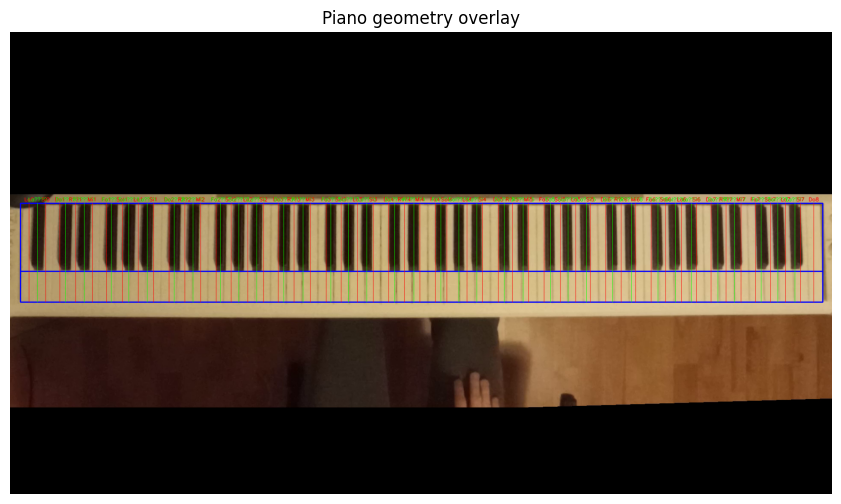

In [ ]:
def draw_piano_geometry_on_frame(
        geometry: PianoGeometry = GEOMETRY,
        points: List[Tuple[float, float]] = None,
        frame: np.ndarray = None,
        show: bool = True,
        figsize: tuple[int, int] = (12, 6),
        save_path: str = "/content/output/piano_geometry_overlay.jpg"
    ) -> np.ndarray:
    """
    Dessine, sur une immage donnée :
      - En BLEU : les 3 lignes horizontales (haut des touches du piano, bas des touches du piano et intersection des touches noires et blanches (bas des touches noires) du piano) et les 2 lignes verticales (la gauche et la droite du piano).
      - En ROUGE : les lignes verticales des touches blanches.
      - En VERT : les lignes verticales des touches noires.
      - En ORANGE : les points de la liste de points "points" (optionnel).
    Retourne l'image annotée (au format BGR).

    Entrées :
        - geometry = Instance de PianoGemoetry, contenant les lignes à tracer
        - frame = image OpenCV d'une frame de la vidéo, par défaut la première frame de la vidéo
        - show = Booléen affichant si vrai la frame annotée avec matplotlib
        - figsize = La taille de la figure matplotlib (si on l'affiche)
        - save_path = Chemin d'enregistrement de l'image annotée (si on l'enregistre)
    """
    # Si on n'a pas donné de frame, on prend la première de la vidéo :
    if frame is None :
        frame = get_frame(VIDEO_PATH, 0)

    # On copie l'image et ses dimensions :
    vis = frame.copy()
    h, w = vis.shape[:2]

    # On prépare les coordonnées x/y bornées à l'image :
    x_left_int  = int(round(geometry.x_left))
    x_right_int = int(round(geometry.x_right))
    y_top_int   = int(round(geometry.y_top_white))
    y_bottom_int = int(round(geometry.y_bottom_white))
    y_black_bottom_int = int(round(geometry.y_black_bottom))

    # On s'assure qu'on reste dans les bornes de l'image :
    x_left_int  = max(0, min(w - 1, x_left_int))
    x_right_int = max(0, min(w - 1, x_right_int))
    y_top_int   = max(0, min(h - 1, y_top_int))
    y_bottom_int = max(0, min(h - 1, y_bottom_int))
    y_black_bottom_int = max(0, min(h - 1, y_black_bottom_int))

    # On trace les 3 lignes horizontales entre x_left et x_right (en bleu) :
    y_lines = [y_top_int, y_bottom_int, y_black_bottom_int]
    for y_int in y_lines:
        cv2.line(vis, (x_left_int, y_int), (x_right_int, y_int), (255, 0, 0), 2)

    # On trace les 2 lignes verticales correspondant aux bords gauche/droite du piano (en bleu) :
    cv2.line(vis, (x_left_int,  y_top_int), (x_left_int,  y_bottom_int), (255, 0, 0), 2)
    cv2.line(vis, (x_right_int, y_top_int), (x_right_int, y_bottom_int), (255, 0, 0), 2)

    # On trace les lignes verticales des touches (en rouge si c'est une touche blanche et en vert sinon (une touche noire)) :
    for key in geometry.keys:
        x_int = int(round(key.x_center))
        # On borne x à l'image pour éviter les débordements :
        x_int = max(0, min(w - 1, x_int))

        color = (0, 0, 255) if key.is_white else (0, 255, 0)
        cv2.line(
            vis,
            (x_int, y_top_int),
            (x_int, y_bottom_int),
            color,
            1
        )

        # On écrit le nom de la touche juste au-dessus de y_top_white sur la même "colonne" que la touche, centré et dans la même couleur (si donné) :
        if key.name is not None:
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.4
            thickness = 1

            # On récupère la taille (largeur, hauteur) du texte en pixels
            (text_width, text_height), _ = cv2.getTextSize(
                key.name, font, font_scale, thickness
            )

            # On centre le texte horizontalement autour de x_int
            text_x = int(x_int - text_width // 2)
            text_y = max(0, y_top_int - 5)

            # On s'assure de ne pas sortir complètement de l'image à gauche
            text_x = max(0, min(text_x, w - text_width))

            cv2.putText(
                vis,
                key.name,
                (text_x, text_y),
                font,
                font_scale,
                color,
                thickness,
                cv2.LINE_AA
            )

    # S'il y en a, on affiche les points (en orange) :
    if points is not None:
        for (x, y) in points:
            x_int = int(round(x))
            y_int = int(round(y))
            if 0 <= x_int < w and 0 <= y_int < h:
                cv2.circle(vis, (x_int, y_int), 5, (0, 140, 255), -1)

    # Si demandé, on sauvegarde l'image :
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        cv2.imwrite(save_path, vis)

    # Si demandé, on affiche l'image :
    if show:
        rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=figsize)
        plt.imshow(rgb)
        plt.axis("off")
        plt.title("Piano geometry overlay")
        plt.show()

    return vis

vizualisation = draw_piano_geometry_on_frame()

Les fonctions suivantes permettent de déterminer pour toute position `(x, y)` la touche située à cet emplacement, à partir du quadrillage précédemment défini.

In [ ]:
def find_pressed_key(
        x: float,
        y: float,
        geometry: PianoGeometry = GEOMETRY
    ) -> Optional[PianoKey]:
    """
    Retourne la touche la plus proche du point (x,y), en respectant les conditions suivantes :
      - Si y > y_black_bottom, on ne considère que les touches blanches,
      - Sinon, si y <= y_black_bottom, on considère toutes les touches (blanches ET noires).
    Retourne None si le point est en-dehors du piano.

    Entrées :
        - geometry = Instance de PianoGeometry (contenant les différentes lignes du piano)
        - x = Coordonnée x du point à tester
        - y = Coordonnée y du point à tester
    """
    # On vérifie que le point (x, y) se trouve bien dans le rectangle global du piano :
        # (En hauteur entre le haut et le bas des touches blanches, et en largeur entre la gauche et la droite du clavier).
    if y < geometry.y_top_white or y > geometry.y_bottom_white:
        return None
    if x < geometry.x_left or x > geometry.x_right:
        return None

    # On sélectionne les touches candidates en fonction de la hauteur du point :
        # En dessous des touches noires (y > y_black_bottom), seulement les touches blanches
        # Au dessus des touches noires (y <= y_black_bottom), toutes les touches (blanches ET noires)
    if y > geometry.y_black_bottom:
        candidates = [k for k in geometry.keys if k.is_white]
    else:
        candidates = list(geometry.keys)

    # Si, on n'a aucune touche candidate, on renvoie None :
    if not candidates:
        return None

    # Parmi toutes les touches candidates, on choisi celle dont le centre horizontal (x_center) est le plus proche de la position x du point (on réalise une projection sur la droite la plus proche).
    best_key = min(candidates, key=lambda k: abs(k.x_center - x))
    return best_key


def find_pressed_key_name(
        x: float,
        y: float,
        geometry: PianoGeometry = GEOMETRY
    ) -> Optional[str]:
    """
    Rends le nom (uniquement) de la touche pressée en fonction de la position donnée pour le point d'appui et du clavier sur l'image.
    """
    # On récupère la touche pressée :
    piano_key = find_pressed_key(x, y, geometry)

    # On rend le nom de la touche (si il y en a une) :
    return piano_key.name if piano_key is not None else None


# On teste avec quelques positions :
positions = [(0, 0), (750, 600)]

for X, Y in positions:
    output = find_pressed_key_name(X, Y)
    print(f"({X}, {Y}) --> {output if output else 'Aucune touche pressée'}")

(0, 0) --> Aucune touche pressée
(750, 600) --> Fa3


#### C. Analyse des touches pressées

Dans cette catégorie, on définit les fonctions permettant de déterminer l'ensemble des touches pressées au cours du temps (à chaque instant) sur la vidéo importée, en utilisant `MMPose` et le **filtre de Savitzky-Golay** (au sens traitement du signal).

Les fonctions `get_joint_coords_for_frame`, `build_frames_info_for_finger` et `flush_segment_for_finger` servent de fonctions utilitaires / auxiliaires aux fonctions principales `detect_piano_notes` et `detect_piano_notes_by_finger`.

La procédure d’estimation des touches pressées par un doigt tout au long de la vidéo est la suivante :
- Pour chaque frame $t$, nous récupérons dans le fichier `.csv` résultat d’estimation de position d’MMPose les coordonnées estimées $(x, y)$ du poignet (joint 0) et du bout du doigt concerné (ex : index = 8).
- On construit la série $y\_rel = y\_tip - y\_wrist$ des différences de hauteur entre le poignet et le bout du doigt et l’on estime au-dessus de quelle touche le doigt étudié est  pour chaque frame de la vidéo.
- On découpe par segments notre série $y\_rel$, chaque segment représentant un ensemble continu des frames au-dessus d’une même touche.
- On applique le filtre de Savitzky-Golay sur chaque segment, avec une fenêtre impaire de taille 3 à 7 et un polynôme de degré 2.
  - On choisit un polynôme de degré 2 car l’on remarque que lorsque le pianiste appuie sur une touche, son doigt s’enfonce, réduisant ainsi la distance entre $y\_tip$ et $y\_wrist$ (et lorsqu’il le relève, la distance s’agrandit de nouveau). Un mouvement d’appui de touche forme donc une parabole sur la série $y\_rel$.
- Une fois notre série $y\_rel$ lissée en $y\_smooth$, on mesure l’amplitude des pics, et nous gardons seulement ceux supérieurs à un seuil arbitraire.
- Lors de la comparaison des estimations aux données réelles, on constate que les prédictions sont souvent en avance de quelques frames (le pianiste prévoyant légèrement en avance la prochaine touche jouée). On avance donc artificiellement de quelques frames l’estimation obtenue.

In [ ]:
from scipy.signal import savgol_filter

BASE_DISP_THRESHOLD = 3.0
MIN_INTERVAL_S = 0.25
LAG_FRAMES = 10


def get_joint_coords_for_frame(
    model_dir: str,
    frame_num: int,
    joint_index: int
) -> Optional[Tuple[float, float]]:
    """
    Renvoie les coordonnées (x, y) du joint `joint_index` à la frame `frame_num`,
    en lisant le fichier CSV correspondant :
        model_dir / f"keypoints_frame_{frame_num}.csv"

    Retourne :
        - (x, y) en float ou None si le fichier n'existe pas ou si les données sont invalides.
    """
    csv_path = os.path.join(model_dir, f"keypoints_frame_{frame_num}.csv")

    # Vérifier que le CSV existe :
    if not os.path.exists(csv_path):
        return None

    # Lecture du CSV :
    try:
        with open(csv_path, newline="", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            rows = list(reader)
    except Exception:
        return None

    # Vérifier qu'on a bien les colonnes x, y et assez de lignes :
    if (
        not rows
        or "x" not in reader.fieldnames
        or "y" not in reader.fieldnames
        or joint_index < 0
        or joint_index >= len(rows)
    ):
        return None

    # Récupérer les coordonnées du joint demandé :
    try:
        x = float(rows[joint_index]["x"])
        y = float(rows[joint_index]["y"])
    except (ValueError, KeyError):
        return None

    return (x, y)


def visualize_savgol_for_segment(
    frames_info: list,
    fps: float,
    t_min: float = None,
    t_max: float = None,
    window_max: int = 7,
    polyorder: int = 2,
    title: str = "y_rel : original vs Savitzky–Golay"
):
    """
    Affiche un "avant / après" du filtre de Savitzky–Golay sur y_rel, pour un ensemble de frames_info (un doigt donné).
    De plus, on grise les zones où, pour les frames successives, le doigt est posé sur UNE MÊME touche (key_name constant et non None).
    """
    # On ne garde que les frames valides avec un y_rel défini :
    valid_entries = [
        d for d in frames_info
        if d.get("valid", False) and d.get("y_rel") is not None
    ]
    if not valid_entries:
        print("Aucun point valide dans frames_info.")
        return

    # Extraction des frames, du signal brut y_rel et des noms de touche :
    frames = np.array([d["frame"] for d in valid_entries], dtype=int)
    y_vals = np.array([d["y_rel"] for d in valid_entries], dtype=float)
    key_names = np.array([d.get("key_name") for d in valid_entries], dtype=object)
    t_vals = frames / float(fps)

    # Filtre temporel optionnel [t_min, t_max] :
    mask = np.ones_like(t_vals, dtype=bool)
    if t_min is not None:
        mask &= (t_vals >= t_min)
    if t_max is not None:
        mask &= (t_vals <= t_max)

    frames = frames[mask]
    y_vals = y_vals[mask]
    t_vals = t_vals[mask]
    key_names = key_names[mask]

    if len(y_vals) < 3:
        print(f"Pas assez de points dans la fenêtre [{t_min}, {t_max}] pour appliquer Savitzky–Golay (len={len(y_vals)}).")
        return

    # Fenêtre Savitzky–Golay :
    L = len(y_vals)
    window = L if L % 2 == 1 else L - 1
    window = min(window, window_max)
    if window < 3:
        window = 3
    if window > L:
        window = L if L % 2 == 1 else L - 1
        if window < 3:
            print(f"Impossible de choisir une fenêtre valide pour len={L}.")
            return

    try:
        y_smooth = savgol_filter(y_vals, window_length=window, polyorder=polyorder)
    except Exception as e:
        print(f"Erreur dans savgol_filter : {e}")
        y_smooth = y_vals

    # Peak détecté sur la courbe lissée :
    peak_idx = int(np.argmax(y_smooth))
    t_peak = t_vals[peak_idx]
    y_peak = y_smooth[peak_idx]

    #  Construction des zones grisées (segments consécutifs avec même key_name non None) :
    shaded_segments = []
    current_key = None
    start_t = None

    for i, k in enumerate(key_names):
        if k is None:
            # Fin éventuelle d'un segment en cours :
            if current_key is not None and start_t is not None:
                end_t = t_vals[i - 1]
                if end_t > start_t:
                    shaded_segments.append((current_key, start_t, end_t))
                current_key = None
                start_t = None
        else:
            if current_key is None:
                # On démarre un nouveau segment :
                current_key = k
                start_t = t_vals[i]
            elif k != current_key:
                # On clôt l'ancien segment et on en démarre un nouveau :
                end_t = t_vals[i - 1]
                if end_t > start_t:
                    shaded_segments.append((current_key, start_t, end_t))
                current_key = k
                start_t = t_vals[i]

    # Si on termine avec un segment ouvert :
    if current_key is not None and start_t is not None:
        end_t = t_vals[-1]
        if end_t > start_t:
            shaded_segments.append((current_key, start_t, end_t))

    #  Plotting :
    plt.figure(figsize=(10, 5))

    # Zones grisées en arrière-plan :
    for key, t_start, t_end in shaded_segments:
        plt.axvspan(t_start, t_end, color="0.9", alpha=0.5, zorder=0)
        t_mid = 0.5 * (t_start + t_end)
        # On met un texte discret (taille petite, un peu translucide) :
        plt.text(
            t_mid,
            np.nanmin(y_vals),
            str(key),
            ha="center",
            va="bottom",
            fontsize=8,
            alpha=0.6,
            rotation=0
        )

    # Courbe brute et courbe lissée :
    plt.plot(t_vals, y_vals, "o-", label="y_rel (brut)", zorder=2)
    plt.plot(t_vals, y_smooth, "-.", label=f"y_rel lissé (SG, window={window})", zorder=3)

    # Marqueur du peak :
    plt.axvline(t_peak, color="red", linestyle="--", alpha=0.6, label=f"Peak (t={t_peak:.3f}s)", zorder=1)
    plt.scatter([t_peak], [y_peak], color="red", zorder=4)

    plt.xlabel("Temps (s)")
    plt.ylabel("y_rel (px)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def build_frames_info_for_finger(
    model_dir: str,
    fingertip_index: int,
    start_frame: int,
    end_frame: int,
    geometry: PianoGeometry = GEOMETRY
) -> List[Dict]:
    """
    Construit la liste `frames_info` pour un doigt donné entre start_frame et end_frame (voir `detect_piano_notes`).
    """
    frames_info = []

    # On parcourt toutes les frames demandées :
    for frame_num in range(start_frame, end_frame + 1):
        csv_path = os.path.join(model_dir, f"keypoints_frame_{frame_num}.csv")

        # Si le CSV n'existe pas, on marque la frame comme invalide :
        if not os.path.exists(csv_path):
            frames_info.append({
                "frame": frame_num,
                "valid": False,
                "key_name": None,
                "y_rel": None,
                "x": None,
                "y": None
            })
            continue

        # Sinon, si le CSV existe, on le lit :
        with open(csv_path, newline="", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            rows = list(reader)

        # On vérifie qu'on a au moins les 21 points et les colonnes x, y :
        if not rows or "x" not in reader.fieldnames or "y" not in reader.fieldnames:
            frames_info.append({
                "frame": frame_num,
                "valid": False,
                "key_name": None,
                "y_rel": None,
                "x": None,
                "y": None
            })
            continue

        # On récupère les coordonnées du poignet et du doigt sélectionné :
        try:
            # Poignet (point 0) :
            y_wrist = float(rows[0]["y"])
            # Doigt sélectionné (tip) :
            x_tip = float(rows[fingertip_index]["x"])
            y_tip = float(rows[fingertip_index]["y"])
        except (KeyError, ValueError, IndexError):
            frames_info.append({
                "frame": frame_num,
                "valid": False,
                "key_name": None,
                "y_rel": None,
                "x": None,
                "y": None
            })
            continue

        # On calcule le déplacement vertical relatif :
        y_rel = y_tip - y_wrist

        # On détermine la touche pressée (s'il y en a une) :
        key_obj = find_pressed_key(x_tip, y_tip, geometry)
        key_name = None if key_obj is None else key_obj.name

        frames_info.append({
            "frame": frame_num,
            "valid": True,
            "key_name": key_name,
            "y_rel": y_rel,
            "x": x_tip,
            "y": y_tip
        })

    return frames_info


def flush_segment_for_finger(
    segment: List[Dict],
    key_name: Optional[str],
    finger_name: str,
    fps: float,
    base_disp_threshold_px: float,
    min_interval_s: float,
    last_note_time: float
) -> Tuple[Optional[Dict], float]:
    """
    Traite un segment (frames consécutives où le doigt est sur la même touche) et on renvoie la note détectée (ou None) ainsi que last_note_time mis à jour.
    """
    # Si le segment est vide ou key_name est None, on ne fait rien :
    if not segment or key_name is None:
        return None, last_note_time

    # Sinon, on récupère y_rel, frames, x et y :
    y_vals = np.array([d["y_rel"] for d in segment], dtype=float)
    frames = np.array([d["frame"] for d in segment], dtype=int)
    xs = np.array([d["x"] for d in segment], dtype=float)
    ys = np.array([d["y"] for d in segment], dtype=float)

    # Si le segment est trop court, on ne fait rien :
    if len(y_vals) < 3:
        return None, last_note_time

    # On applique un lissage (fenêtre impaire <= 7, poly ordre 2) :
    try:
        window = min(len(y_vals) if len(y_vals) % 2 == 1 else len(y_vals) - 1, 7)
        if window < 3:
            window = 3
        y_smooth = savgol_filter(y_vals, window_length=window, polyorder=2)
    except Exception:
        y_smooth = y_vals

    # On calcule l'amplitude dans ce segment :
    amp = float(y_smooth.max() - y_smooth.min())

    # On vérifie que l'amplitude dépasse le seuil (dynamique) :
    disp_threshold = max(base_disp_threshold_px, 0.15 * amp)
    if amp < disp_threshold:
        return None, last_note_time

    # On prend le maximum (peak, moment où "y_smooth" est maximal) comme instant d'appui :
    peak_idx = int(np.argmax(y_smooth))
    frame_peak = int(frames[peak_idx])
    t_peak = frame_peak / fps
    x_peak = float(xs[peak_idx])
    y_peak = float(ys[peak_idx])

    # On vérifie que le délai minimal depuis la dernière note détectée est valide pour ce doigt :
    if t_peak - last_note_time < min_interval_s:
        return None, last_note_time

    note = {
        "doigt": finger_name,
        "frame": frame_peak,
        "timestamp": round(t_peak, 3),
        "x_px": round(x_peak, 2),
        "y_px": round(y_peak, 2),
        "key_name": key_name,
        "amplitude_px": round(amp, 2)
    }
    last_note_time = t_peak
    return note, last_note_time


def detect_piano_notes_by_finger(
        model,
        finger_name: str,
        fingertip_index: int,
        video_path: str,
        geometry: PianoGeometry = GEOMETRY,
        base_disp_threshold_px: float = BASE_DISP_THRESHOLD,
        min_interval_s: float = MIN_INTERVAL_S,
        lag_frames: int = LAG_FRAMES
    ) -> List[Dict]:
    """
    Détecte les appuis de touches (notes jouées) pour un doigt donné à partir :
      - Des keypoints MMPose enregistrés en CSV,
      - De la géométrie du piano (objet `geometry`), permettant de mapper les coordonnées (x, y) du doigt vers une touche.

    Voir `detect_piano_notes` pour la description détaillée du principe et des entrées / sorties.
    """
    # Récupération du modèle et de sa configuration :
    model_name = getattr(model, "model_name", MODELS_CONFIG[0]["name"])
    model_config = [model for model in MODELS_CONFIG if model['name'] == model_name][0]
    model_dir = os.path.join(OUTPUT_DIR, model_name)

    # Récupèration des fps (et génère les CSV) :
    fps = get_keypoints_from_models(video_path, [model_config], START_TIME_SEC, END_TIME_SEC)

    # Construction de la timeline du doigt :
    frames_info = build_frames_info_for_finger(
        model_dir,
        fingertip_index,
        int(START_TIME_SEC * fps),
        int(END_TIME_SEC * fps) + 1,
        geometry
    )

    # Découpage en segments pour lesquels key_name est constant et non None :
    current_key = None
    last_note_time = -1e9 # Pour min_interval_s.
    notes = []
    segment = [] # Liste de dictionnaires frames_info pour ce segment.

    # On parcourt toute la timeline :
    for info in frames_info:
        key_name = info.get("key_name", None)
        valid = info.get("valid", False)

        # Cas où la frame est invalide ou le doigt n'est pas sur une touche :
        if not valid or key_name is None:
            # Alors, on flush / termine le segment en cours (s'il y en a un) :
            if segment and current_key is not None:
                note, last_note_time = flush_segment_for_finger(
                    segment,
                    current_key,
                    finger_name,
                    fps,
                    base_disp_threshold_px,
                    min_interval_s,
                    last_note_time,
                )
                if note is not None:
                    notes.append(note)
            # On réinitialise le segment :
            segment = []
            current_key = None
            continue

        # Cas où la frame est valide et le doigt est sur une touche :
        if current_key is None: # # On commence un nouveau segment.
            current_key = key_name
            segment = [info]
        elif key_name == current_key: # On continue le segment en cours.
            segment.append(info)
        else: # Changement de touche (on flush l'ancien segment, on en commence un nouveau) :
            note, last_note_time = flush_segment_for_finger(
                segment,
                current_key,
                finger_name,
                fps,
                base_disp_threshold_px,
                min_interval_s,
                last_note_time
            )
            if note is not None:
                notes.append(note)
            current_key = key_name
            segment = [info]

    # Prise en compte du lag de frames (décalage de `lag_frames` frames par rapport à la frame prédite) :
    for note in notes:
        # On récupère les informations de la nouvelle frame :
        new_frame_idx = note["frame"] + lag_frames
        new_frame_timestamp = note["timestamp"] + lag_frames / fps
        new_frame_coords = get_joint_coords_for_frame(model_dir, new_frame_idx, fingertip_index)

        # Si la nouvelle frame est valide (le joint existe / a des coordonnées valides), on la remplace :
        if new_frame_coords is not None:
            note["frame"] = new_frame_idx
            note["timestamp"] = new_frame_timestamp
            note["x_px"] = new_frame_coords[0]
            note["y_px"] = new_frame_coords[1]
            note["key_name"] = find_pressed_key_name(new_frame_coords[0], new_frame_coords[1], geometry)

    return notes


def detect_piano_notes(
    model,
    video_path: str,
    geometry: PianoGeometry = GEOMETRY,
    base_disp_threshold_px: float = BASE_DISP_THRESHOLD,
    min_interval_s: float = MIN_INTERVAL_S,
    lag_frames: int = LAG_FRAMES,
    included_fingers: Optional[List[str]] = None
) -> List[Dict]:
    """
    Détecte les appuis de touches (notes jouées) à partir :
      - Des keypoints MMPose enregistrés en CSV,
      - De la géométrie du piano (objet `geometry`), permettant de mapper les coordonnées (x, y) du doigt vers une touche.

    Principe :
        (1) On ne conserve que les doigts spécifiés dans `included_fingers`.
        (2) Pour chaque frame, on lit les deux keypoints suivants :
               - Poignet (point 0),
               - Extrémité du doigt choisi (point 8 pour l'index (Hand21)),
            Puis on calcule un signal vertical relatif :
               y_rel = y_doigt - y_poignet
        (3) On regroupe les frames en segments où le doigt reste au-dessus du clavier (contact continu avec la zone des touches).
        (4) Pour chaque segment :
                - On lisse le signal y_rel,
                - On mesure l'amplitude (max / min),
                - Si l'amplitude est inférieure à un seuil, on ignore le segment,
                - Sinon on estime l'instant d'appui (frame du "peak" décalée de `lag_frames` frames) et on projette la position moyenne du doigt sur la touche la plus proche via `geometry`.
        (5) On applique un délai minimal `min_interval_s` entre deux appuis successifs pour éviter les doublons.

    Entrées :
        - model : instance MMPose déjà chargée (un seul modèle de main 2D).
        - video_path : chemin vers la vidéo d'entrée.
        - geometry : objet décrivant la géométrie du piano.
        - base_disp_threshold_px : seuil de base (en pixels) sur l'amplitude du signal y_rel à l'intérieur d'un segment pour qu'un appui soit considéré comme valide.
        - min_interval_s : durée minimale (en secondes) entre deux appuis successifs pour un même doigt.
        - lag_frames : nombre de frames dont on décale l'instant d'appui par rapport au peak détecté.
        - included_fingers : liste optionnelle des doigts à considérer parmi `["Pouce", "Index", "Majeur", "Annulaire", "Auriculaire"]`.

    Retour :
        Liste de dictionnaires, chacun décrivant un appui détecté, de la forme :
        {
            "doigt": "Index",     # Doigt ayant réalisé l'appui
            "frame": int,         # Numéro de frame de l'appui (après décalage)
            "timestamp": float,   # Temps en secondes (frame / fps)
            "x_px": float,        # Abscisse du doigt à l'instant de l'appui (pixels)
            "y_px": float,        # Ordonnée du doigt à l'instant de l'appui (pixels)
            "key_name": str,      # Nom de la touche estimée (ex. "Sol 4")
            "amplitude_px": float # Amplitude du mouvement vertical relatif dans le segment (en pixels)
        }.
    """
    # On récupère les indices des doigts à analyser :
    fingertip_indices = {"Pouce": 4, "Index": 8, "Majeur": 12, "Annulaire": 16, "Auriculaire": 20}
    default_fingers = ["Pouce", "Index", "Majeur", "Annulaire", "Auriculaire"]

    if included_fingers is None:
        included_fingers = default_fingers
    included_fingers = [finger for finger in included_fingers if finger in fingertip_indices]

    if not included_fingers:
        raise ValueError("Aucun doigt valide dans included_fingers.")

    # On traite chaque doigt séparément et on agrège les résultats :
    all_notes = []
    for finger_name in included_fingers:
        notes = detect_piano_notes_by_finger(
            model,
            finger_name,
            fingertip_indices[finger_name],
            video_path,
            geometry,
            base_disp_threshold_px,
            min_interval_s,
            lag_frames
        )
        all_notes.extend(notes)

    # Tri final par frame :
    all_notes.sort(key=lambda note: note["frame"])
    return all_notes

#### D. Estimation des notes pressées

Le code ci-dessous affiche l'ensemble des notes pressées pour la vidéo sélectionnée entre `START_TIME_SEC` et `END_TIME_SEC` secondes :

In [ ]:
model = load_mmpose_models([MODELS_CONFIG[0]])[0]

notes = detect_piano_notes(
    model,
    VIDEO_PATH,
    lag_frames = 10,
    included_fingers = ["Index"]
)

print(f"\nNotes détectées ({len(notes)}) :")
for n in notes:
    frame_name = f"frame_{n['frame']}.jpg"
    print(
        f"[{n['timestamp']:6.3f}s]  {n['key_name'] or '-----':<5}  {n['doigt']:<11}  {frame_name:<14}  ({n['x_px']:7.2f}, {n['y_px']:6.2f})  amp={n['amplitude_px']:.2f}px"
    )

In [ ]:
model_name = getattr(model, "model_name", MODELS_CONFIG[0]["name"])
model_config = [m for m in MODELS_CONFIG if m["name"] == model_name][0]
model_dir = os.path.join(OUTPUT_DIR, model_name)

fps = get_keypoints_from_models(VIDEO_PATH, [model_config], START_TIME_SEC, END_TIME_SEC)

frames_info_index = build_frames_info_for_finger(
    model_dir=model_dir,
    fingertip_index=8,
    start_frame=int(START_TIME_SEC * fps),
    end_frame=int(END_TIME_SEC * fps),
    geometry=GEOMETRY
)

visualize_savgol_for_segment(
    frames_info_index,
    fps=fps,
    t_min=2.0,
    t_max=4.0,
    window_max=7,
    polyorder=2
)

Suite à l’application de cette méthode, nous déterminons ~95% des moments où une touche est réellement pressée, avec la bonne note de détectée ~80-90% du temps (les 10-20% restants détectent également l’appui mais par erreur sur une touche adjacente).  
Il y a également ~15% de fausses notes prédites.

### 3. Estimation de la prochaine note jouée

Dans cette partie, le but principal est de trouver la prochaine note jouée par le pianiste si on coupe la vidéo un peu avant qu'il joue cette note.

Pour cela, le modèle observe la main à deux instants clés : le départ ($P_{0\%}$) et un point d'intérêt à 80% du trajet temporel ($P_{80\%}$). Le ratio de 80% a été choisi de telle sorte à ce que le modèle aie suffisamment d'informations sans avoir les plus importantes.

Naïvement, prolonger la trajectoire donne juste de mauvais résultats car la vitesse le long de la trajectoire n'est pas constante. De plus, ajouter un coefficient fixe qui réduit l'impact du mouvement à partir du point le plus proche de la note (celui à 80%) est une bonne stratégie mais moins performante. Cette stratégie pourrait s'écrire :

$$xy_{pred} = xy_{80\%} + (xy_{80\%} - xy_{0\%}) \times coef$$
Avec $coef = 0.12$ par exemple

Un modèle préférable car plus performant doit adapter son coefficient dynamiquement.  
**Techniquement le modèle est une forme d'extrapolation linéaire à coefficient dynamique.**

Il s'écrit alors :

$$X_{pred} = x_{80\%} + (x_{80\%} - x_{0\%}) \times C(t_{restant})$$
$$Y_{pred} = y_{80\%} + (y_{80\%} - y_{0\%}) \times C(t_{restant})$$

Avec :

$$
C(t_{restant}) =
\begin{cases}
0 & \text{si } t_{restant} \leq 0.2 \\
0.4 \times \left( \frac{t_{restant} - 0.2}{0.3} \right)^2 & \text{si } 0.2 < t_{restant} < 0.5 \\
0.4 & \text{si } t_{restant} \geq 0.5
\end{cases}
$$

Le temps $t_{restant}$ est la différence de temps entre le point à 80% et celui à 100%. Cette caractéristique est intéressante car elle va nous permettre d'adapter le coefficient de l'interpolation avec la fonction $C$ à l'aide d'observations physiologiques générales d'un pianiste.
* **L'anticipation de la note jouée :** À l'approche de la note ($< 0.2s$), on considère que le pianiste est déjà positionné sur la bonne note ou l'est quasiment car tout pianiste anticipe son déplacement pour augmenter sa précision. Ici, l'extrapolation devient inutile : on récupère directement la note à 80% (le coefficient vaut alors 0).
* **L'accélération progressive vers la note :** Si l'écart entre deux notes devient important (entre $0.2s$ et $0.5s$), il y aura alors progressivement moins d'informations à l'instant du point à 80% de la note finale. On doit alors augmenter progressivement le coefficient de la projection pour augmenter l'importance de la vitesse dans la détection de la note finale.
* **Les notes suivantes sont souvent proches de la note initiale :** A comprendre que plus le déplacement est grand, plus tôt doit se déplacer la main. A plus de $0.5s$, on a un réel manque d'information, ce qui implique que soit le déplacement est grand alors on considère que le pianiste est déjà au milieu de son déplacement, soit il n'a pas encore bougé dans ce cas là la note est assez proche : d'où la valeur du coefficient à $0.4$. Ce coefficient est alors plafonné pour ne pas qu'il explose et donne une note beaucoup trop éloignée, voire hors du piano (en particulier avec l'axe y). On limite par là le manque d'informations du fait de la valeur élevée de $t_{restant}$.

A noter que nous avons opté pour une progression quadratique de $C$ sur $[0.2;0.5]$ qui représente mieux la réalité terrain d'après nous, car cela permet de corriger la note prédite progressivement.

#### A. Récupération du fichier midi

In [ ]:
import os
from google.colab import files

# Création du dossier de réception
os.makedirs("/content/midi", exist_ok=True)

print("Veuillez uploader le fichier MIDI adapté à la vidéo")
uploaded_midi = files.upload()
midi_src_name = next(iter(uploaded_midi))

if not (midi_src_name.lower().endswith(".mid") or midi_src_name.lower().endswith(".midi")):
    raise ValueError("Le fichier n'est pas au format MIDI (.mid ou .midi).")

MIDI_PATH = os.path.join("/content/midi", midi_src_name)
with open(MIDI_PATH, "wb") as f:
    f.write(uploaded_midi[midi_src_name])

print(f"Fichier MIDI prêt : {MIDI_PATH}")

#### B. Fonctions de prédiction

In [ ]:
import librosa
import warnings
import numpy as np
import pretty_midi
from scipy import signal

warnings.filterwarnings("ignore", category=UserWarning) # Warnings de dépendances (inutile)
warnings.filterwarnings("ignore", category=FutureWarning)

def synchronize_audio_midi(video_path, midi_path, sr=22050, hop_length=512):
    """ Calcule le décalage audio/midi pour la piste précise dans le midi (découpage de l'audio)"""
    y, _ = librosa.load(video_path, sr=sr)

    chroma_audio = librosa.feature.chroma_stft(y=y,sr=sr,hop_length=hop_length,n_fft=2048)

    fs_frames = sr / hop_length
    pm = pretty_midi.PrettyMIDI(midi_path)
    chroma_midi = pm.get_chroma(fs=fs_frames)

    audio_flux = np.sum(np.maximum(0, np.diff(chroma_audio, axis=1)), axis=0)
    midi_flux  = np.sum(np.maximum(0, np.diff(chroma_midi, axis=1)), axis=0)

    # Normalisation
    audio_flux = (audio_flux - np.mean(audio_flux)) / (np.std(audio_flux) + 1e-8)
    midi_flux  = (midi_flux  - np.mean(midi_flux))  / (np.std(midi_flux)  + 1e-8)

    correlation = signal.correlate(audio_flux, midi_flux, mode="full")
    lags = signal.correlation_lags(len(audio_flux), len(midi_flux))

    return lags[np.argmax(correlation)] / fs_frames

def get_midi_impact_points(midi_path, fps, offset, start_lim, end_lim):
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    all_notes = []
    for inst in midi_data.instruments:
        if not inst.is_drum: all_notes.extend(inst.notes)

    all_notes.sort(key=lambda x: x.start)

    impacts = []
    for note in all_notes:
        real_time = note.start + offset
        if start_lim <= real_time <= end_lim:
            impacts.append({
                'pitch': note.pitch,
                'note_name': get_european_note_name(note.pitch),
                'time_impact': real_time,
                'frame_impact': int(real_time * fps)
            })
    print(f"Il y a {len(impacts)} notes dans le fichier MIDI.")
    return impacts

def get_interest_points(impact_points, fps, ratio=0.8):
    """ Renvoie deux listes de points, les points correspondant à touche pressée
    (starts) et ceux à -ratio- de la distance temporelle entre deux notes (interests) """
    starts = []
    interests = []

    if not impact_points:
        return starts, interests

    # Cas de la première note, on prend un intervalle de 0.5 secondes par défaut l'appui et les points d'intérêts
    first_note = impact_points[0]
    virtual_start_time = max(0, first_note['time_impact'] - 0.5)
    starts.append({
        'frame_start': int(virtual_start_time * fps),
        'note_name': "?"
    })
    time_interest_first = virtual_start_time + ratio * (first_note['time_impact'] - virtual_start_time)
    interests.append({
        'next_note_name': first_note['note_name'],
        'frame_interest': int(time_interest_first * fps),
        'frame_target': first_note['frame_impact']
    })

    for i in range(1, len(impact_points)):
        note_depart = impact_points[i - 1]
        note_cible = impact_points[i]

        diff_time = note_cible['time_impact'] - note_depart['time_impact']

        if diff_time > 0.05:
            starts.append({
                'frame_start': note_depart['frame_impact'],
                'note_name': note_depart['note_name']
            })

            time_interest = note_depart['time_impact'] + ratio * diff_time
            interests.append({
                'next_note_name': note_cible['note_name'],
                'frame_interest': int(time_interest * fps),
                'frame_target': note_cible['frame_impact']
            })

    print(f"Synchronisation terminée : {len(starts)} segments identifiés (Sol inclus).")
    return starts, interests

def predict_next_note_position(model_name, starts, interests, fps):
    model_dir = os.path.join(OUTPUT_DIR, model_name)
    results = []

    for i in range(len(starts)):
        info_start = starts[i]
        info_interest = interests[i]

        # Calcul du temps restant avant l'impact
        frames_remaining = info_interest['frame_target'] - info_interest['frame_interest']
        time_remaining = frames_remaining / fps

        p_start = os.path.join(model_dir, f"keypoints_frame_{info_start['frame_start']}.csv")
        p_interest = os.path.join(model_dir, f"keypoints_frame_{info_interest['frame_interest']}.csv")

        if os.path.exists(p_start) and os.path.exists(p_interest):
            with open(p_start, "r") as f: row_start = list(csv.DictReader(f))[8]
            with open(p_interest, "r") as f: row_interest = list(csv.DictReader(f))[8]

            x_s, y_s = float(row_start['x']), float(row_start['y'])
            x_i, y_i = float(row_interest['x']), float(row_interest['y'])

            if time_remaining <= 0.2:
                coef = 0.0
            elif time_remaining >= 0.5:
                coef = 0.4
            else:
                # Formule quadratique : 0.4 * (t_norm / 0.3)^2
                t_normalized = time_remaining - 0.2
                coef = 0.4 * (t_normalized / 0.3)**2

            # Calcul du vecteur de mouvement
            diff_x = x_i - x_s
            diff_y = y_i - y_s

            # Prédiction
            pred_x = x_i + (diff_x * coef)
            pred_y = y_i + (diff_y * coef)

            # Clipping de sécurité
            pred_x = max(0, min(1920, pred_x))
            pred_y = max(0, min(1080, pred_y))

            results.append({
                'target_note': info_interest['next_note_name'],
                'pred_coords': (pred_x, pred_y),
                'frame_interest': info_interest['frame_interest'],
                'coef_applied': coef # Pour vérifier la fluidité
            })

    return results

def get_european_note_name(note_number):
    # Noms anglais vers français
    names_fr = ["Do", "Do♯", "Ré", "Ré♯", "Mi", "Fa", "Fa♯", "Sol", "Sol♯", "La", "La♯", "Si"]

    octave = (note_number // 12) - 1
    note_idx = note_number % 12

    return f"{names_fr[note_idx]}{octave}"

#### C. Fonction de visualisation

In [ ]:
def plot_velocity_profile(model_name, start_frame, target_frame, fps, note_start="?", note_target="?", segment_idx=0, window_size=3):
    model_dir = os.path.join(OUTPUT_DIR, model_name)
    frames, x_coords, y_coords = [], [], []

    # 1. Collecte des données
    for frame in range(start_frame, target_frame + 1):
        file_path = os.path.join(model_dir, f"keypoints_frame_{frame}.csv")
        if os.path.exists(file_path):
            with open(file_path, "r") as csv_file:
                rows = list(csv.DictReader(csv_file))
                row = rows[8] # Poignet/Doigt
                frames.append(frame)
                x_coords.append(float(row['x']))
                y_coords.append(float(row['y']))

    if len(frames) < 2:
        return

    # Calcul des timecodes
    time_start = start_frame / fps
    time_end = target_frame / fps
    total_duration = time_end - time_start

    # 2. Calcul des vitesses
    velocities = [np.sqrt((x_coords[i]-x_coords[i-1])**2 + (y_coords[i]-y_coords[i-1])**2) * fps for i in range(1, len(x_coords))]

    # 3. Lissage
    if len(velocities) > window_size:
        smoothed_velocities = np.convolve(velocities, np.ones(window_size)/window_size, mode='same')
    else:
        smoothed_velocities = velocities

    time_axis = [(frame - start_frame) / fps for frame in frames[1:]]

    # 4. Graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    full_title = (f"SEGMENT {segment_idx} : {note_start} ➔ {note_target}\n"
                  f"Intervalle : {total_duration:.3f}s | Timecodes : {time_start:.2f}s ➔ {time_end:.2f}s")
    fig.suptitle(full_title, fontsize=12, fontweight='bold')

    # --- Trajectoire ---
    ax1.plot(x_coords, y_coords, 'o-', color='blue', alpha=0.3, label='Trajet')
    ax1.scatter(x_coords[0], y_coords[0], color='green', s=100, label=f'Départ ({note_start})')
    ax1.scatter(x_coords[-1], y_coords[-1], color='red', s=100, label=f'Cible ({note_target})')
    interest_idx = int(len(x_coords) * 0.8)
    if interest_idx < len(x_coords):
        ax1.scatter(x_coords[interest_idx], y_coords[interest_idx], color='orange', s=100, zorder=5, label='Point d\'intérêt (80%)')
    ax1.invert_yaxis() # Correspond au piano de la vidéo
    ax1.set_aspect('equal', adjustable='datalim')
    ax1.set_title("Trajectoire spatiale (Ratio 1:1)")
    ax1.legend()

    # --- Vitesse ---
    ax2.plot(time_axis, velocities, color='purple', alpha=0.2, label='Brute')
    ax2.plot(time_axis, smoothed_velocities, color='purple', lw=3, label='Lissée')
    ax2.fill_between(time_axis, smoothed_velocities, color='purple', alpha=0.1)

    relative_interest_time = total_duration * 0.8
    ax2.axvline(x=relative_interest_time, color='orange', linestyle='--', lw=2, label='Capture (80%)')
    ax2.text(relative_interest_time, max(velocities)*0.8, '  Prédiction', color='orange', fontweight='bold')

    ax2.set_title(f"Profil de Vitesse (Lissage w={window_size})")
    ax2.set_xlabel("Temps relatif (sec)")
    ax2.set_ylabel("Pixels/sec")
    ax2.legend()

    plt.tight_layout()
    plt.show()

# --- EXEMPLE D'UTILISATION ---
START_TIME_SEC, END_TIME_SEC = 0, 40
video_capture = cv2.VideoCapture(VIDEO_PATH)
fps_value = video_capture.get(cv2.CAP_PROP_FPS)
video_capture.release()

# get_velocities_from_models(VIDEO_PATH, [MODELS_CONFIG[0]], START_TIME_SEC, END_TIME_SEC)
time_offset = synchronize_audio_midi(VIDEO_PATH, MIDI_PATH)
midi_impacts = get_midi_impact_points(MIDI_PATH, fps_value, time_offset, START_TIME_SEC, END_TIME_SEC)
starts_list, interests_list = get_interest_points(midi_impacts, fps_value)

if len(interests_list) > 0:
    start_idx = 0
    display_count = 10
    end_idx = min(start_idx + display_count, len(interests_list))

    for i in range(start_idx, end_idx):
        segment_start = starts_list[i]
        segment_interest = interests_list[i]

        plot_velocity_profile(
            model_name=MODELS_CONFIG[0]["name"],
            start_frame=segment_start['frame_start'],
            target_frame=segment_interest['frame_target'],
            fps=fps_value,
            note_start=segment_start['note_name'],
            note_target=segment_interest['next_note_name'],
            segment_idx=i+1
        )

#### D. Prédiction finale

In [ ]:
# --- CONFIGURATION ---
START_TIME_SEC = 0
END_TIME_SEC = 10

# --- INITIALISATION ---
cap = cv2.VideoCapture(VIDEO_PATH)
video_fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

print(f"Lancement de l'analyse : {START_TIME_SEC}s à {END_TIME_SEC}s")

# Étape 0 : Extraction des vitesses (À décommenter si besoin de recalculer MMPose)
# get_velocities_from_models(VIDEO_PATH, [MODELS_CONFIG[0]], START_TIME_SEC, END_TIME_SEC, True)

# Étape 1 : Synchronisation AUDIO (Calcul du décalage avec Onset Flux)
try:
    time_offset = synchronize_audio_midi(VIDEO_PATH, MIDI_PATH)
    print(f"\n>>> Décalage trouvé via Audio : {time_offset:.3f}s")
except Exception as error:
    print(f"Erreur de synchro audio : {error}")
    time_offset = 0

# Étape 2 : Extraction des impacts MIDI avec le décalage calculé
midi_impacts = get_midi_impact_points(MIDI_PATH, video_fps, time_offset, START_TIME_SEC, END_TIME_SEC)

if midi_impacts:
    # Étape 3 : Points d'intérêt (Génération des segments, incluant le Sol initial avec "?")
    starts_list, interests_list = get_interest_points(midi_impacts, video_fps)

    # Étape 4 : Prédiction (Vecteur de mouvement à 80% + extension de 12%)
    predictions = predict_next_note_position(MODELS_CONFIG[0]["name"], starts_list, interests_list, video_fps)

    # --- AFFICHAGE DES RÉSULTATS ---
    print(f"\n{'Frame':<10} | {'Timing':<10} | {'Note Réelle':<12} | {'Note Prédite':<12} | {'X Prédit':<10} | {'Y Prédit':<10}")
    print("-" * 90)

    if not predictions:
        print("Aucune prédiction n'a pu être générée (fichiers CSV manquants ou mains non détectées).")
    else:
        sorted_predictions = sorted(predictions, key=lambda x: x['frame_interest'])

        correct_count = 0
        for pred in sorted_predictions:
            current_frame = pred['frame_interest']
            timing_sec = current_frame / video_fps
            real_note = pred['target_note']

            # --- Étape 5 : Traduction des coordonnées en note via la géométrie du piano ---
            x_pred, y_pred = pred['pred_coords']
            predicted_key_name = find_pressed_key_name(x_pred, y_pred)
            predicted_note = predicted_key_name if predicted_key_name else "???"

            if predicted_note == real_note:
                correct_count += 1

            x_coord_str = f"{x_pred:.1f}"
            y_coord_str = f"{y_pred:.1f}"
            print(f"{current_frame:<10} | {timing_sec:<10.2f} | {real_note:<12} | {predicted_note:<12} | {x_coord_str:<10} | {y_coord_str:<10}")

        print("-" * 90)

        # --- RÉCAPITULATIF FINAL ---
        accuracy = (correct_count / len(sorted_predictions)) * 100
        print(f"Analyse terminée : {correct_count}/{len(sorted_predictions)} notes correctement prédites.")
        print(f"Taux de précision : {accuracy:.1f}%")
else:
    print("ERREUR : Aucun impact MIDI trouvé. Vérifiez le fichier MIDI ou le décalage.")

## Axes d'amélioration

Quelques améliorations que nous pourrions apporter seraient d’étendre notre algorithme pour fonctionner avec 2 mains, y compris lorsqu’elles se superposent.  
Sinon, on a accompli tous nos objectifs.